# Visualización de Tablas

En este notebook nos haremos preguntas sobre el _dataset_ Encuesta Origen-Destino de Santiago 2012, también conocida como EOD2012. Esta encuesta fue realizara para la [Secretaría de Transporte](https://www.sectra.gob.cl/biblioteca/detalle1.asp?mfn=3253).

## Preámbulo

In [2]:
from dotenv import load_dotenv
import os
import sys
from pathlib import Path

load_dotenv()

AVES_ROOT = Path(os.environ['AVES_ROOT'])
EOD_PATH = AVES_ROOT / "data" / "external" / "EOD_STGO"
EOD_PATH

PosixPath('/home/egraells/resources/aves/data/external/EOD_STGO')

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from aves.data import eod
from aves.features.utils import normalize_rows, normalize_columns
from aves.config import setup_style

setup_style(font_scale=0.85)

## Datos

La EOD2012 contiene varias base de datos. Cargaremos primero la de _personas_.

In [4]:
personas = eod.read_people(EOD_PATH)
personas

,Hogar,Persona,AnoNac,Sexo,Relacion,Viajes,LicenciaConducir,PaseEscolar,AdultoMayor,Estudios,...,TramoIngreso,IngresoFinal,TramoIngresoFinal,IngresoImputado,Factor_LaboralNormal,Factor_SabadoNormal,Factor_DomingoNormal,Factor_LaboralEstival,Factor_FindesemanaEstival,FactorPersona
0,100010,10001001,1958,Hombre,Jefe(a) de Hogar,2,3,2,2,4.0,...,Entre 200.001 y 400.000 pesos,240000,2,0,NaN,NaN,1668.2600,NaN,NaN,82.58553
1,100010,10001002,1956,Mujer,Cónyuge o pareja,5,1,2,2,5.0,...,NaN,0,0,0,NaN,NaN,852.1137,NaN,NaN,99.53422
2,100010,10001003,1982,Mujer,Hijo o Hija,0,1,2,2,7.0,...,Entre 200.001 y 400.000 pesos,210845,2,2,NaN,NaN,1609.1630,NaN,NaN,151.59367
3,100020,10002001,1954,Hombre,Jefe(a) de Hogar,4,3,2,2,4.0,...,Menos de 200.000 pesos,133000,1,0,169.50230,NaN,NaN,NaN,NaN,45.21325
4,100020,10002002,1961,Mujer,Cónyuge o pareja,2,1,2,2,4.0,...,Menos de 200.000 pesos,193000,1,0,43.26765,NaN,NaN,NaN,NaN,25.62248
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60049,706791,70679101,1956,Mujer,Cónyuge o pareja,2,1,2,2,4.0,...,NaN,0,0,0,NaN,NaN,320.9519,NaN,NaN,17.87670
60050,706791,70679102,1955,Hombre,Jefe(a) de Hogar,0,1,2,2,5.0,...,Entre 200.001 y 400.000 pesos,396715,2,2,NaN,NaN,320.9519,NaN,NaN,21.07324
60051,743813,74381301,1943,Hombre,Jefe(a) de Hogar,2,1,2,2,5.0,...,Menos de 200.000 pesos,140369,1,2,NaN,NaN,281.4610,NaN,NaN,15.34897
60052,743813,74381302,1943,Mujer,Cónyuge o pareja,2,1,2,2,4.0,...,Menos de 200.000 pesos,177636,1,2,NaN,NaN,288.1693,NaN,NaN,17.30931


Noten que cada persona tiene un identificador único `Persona` y un identificador no único `Hogar`. 

Le agregaremos dos atributos a la tabla:

* `Edad`: atributo cuantitativo definido como el año 2013 menos el año de nacimiento.
* `GrupoEtareo`: atributo ordinal definido como grupos de edad de 5 años. Se calcula a partir de `Edad` con la operación módulo.

In [5]:
personas["Edad"] = 2013 - personas["AnoNac"]

personas["GrupoEtareo"] = personas["Edad"] - (personas["Edad"] % 5)
personas["GrupoEtareo"].value_counts()

GrupoEtareo
20     5348
25     4571
15     4472
50     4248
40     4173
45     4008
30     4004
10     3898
35     3769
5      3694
55     3601
60     2998
0      2953
65     2775
70     2128
75     1423
80     1111
85      590
90      222
95       58
100       9
105       1
Name: count, dtype: int64

También leeremos la tabla de _hogares_. En esta tabla, cada fila representa a un hogar, esta vez con identificador `Hogar` único.

In [6]:
hogares = eod.read_homes(EOD_PATH)
hogares

,Hogar,Sector,Zona,Comuna,DirCoordX,DirCoordY,Fecha,DiaAsig,TipoDia,Temporada,...,NumVeh,NumBicAdulto,NumBicNino,Propiedad,MontoDiv,ImputadoDiv,MontoArr,ImputadoArr,IngresoHogar,FactorHogar
0,100010,Extensión Sur-Poniente,786,BUIN,335180.8019,6266420.975,14-04-2013,domingo,2,1,...,1,1,0,2,53000.0,0,100000,0,450845,136.393738
1,100020,Extensión Sur-Poniente,785,BUIN,338410.2114,6265607.141,10-04-2013,miércoles,1,1,...,1,3,0,1,NaN,0,120000,0,1019369,73.843597
2,100030,Extensión Sur-Poniente,791,BUIN,327863.8248,6257800.086,23-08-2013,viernes,1,1,...,0,0,0,3,NaN,0,70000,0,80000,180.722809
3,100041,Extensión Sur-Poniente,791,BUIN,327864.0000,6257800.000,23-08-2013,viernes,1,1,...,0,1,0,1,NaN,0,80000,0,559259,150.379059
4,100052,Extensión Sur-Poniente,783,BUIN,338480.8152,6267296.941,08-08-2013,jueves,1,1,...,0,0,0,1,NaN,0,117771,1,710309,122.001518
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18259,700990,Extensión Sur-Poniente,785,BUIN,339104.1011,6263063.925,24-11-2013,domingo,2,1,...,0,1,1,1,NaN,0,100000,0,300000,75.526031
18260,706781,Poniente,69,CERRO NAVIA,338539.1741,6299539.203,24-11-2013,domingo,2,1,...,0,2,2,1,NaN,0,140000,0,695186,174.348663
18261,706791,Poniente,69,CERRO NAVIA,338563.2201,6299580.118,24-11-2013,domingo,2,1,...,0,0,0,1,NaN,0,200000,0,396715,71.358963
18262,743813,Sur,244,LA GRANJA,349410.2812,6289668.962,24-11-2013,domingo,2,1,...,0,0,0,1,NaN,0,80000,0,318005,68.410446


Finalmente cargamos la tabla de _viajes_, que tiene un viaje en cada fila. Cada `Viaje` es único, fue hecho por una `Persona`, que vive en un `Hogar`.

In [7]:
viajes = eod.read_trips(EOD_PATH)
viajes

,Hogar,Persona,Viaje,Etapas,ComunaOrigen,ComunaDestino,SectorOrigen,SectorDestino,ZonaOrigen,ZonaDestino,...,FactorDomingoNormal,FactorLaboralEstival,FactorFindesemanaEstival,CodigoTiempo,ModoDifusion,DistEuclidiana,DistManhattan,Imputada,TipoDia,FactorExpansion
0,173431,17343102,1734310202,1,Maipú,Maipú,Poniente,Poniente,400,407,...,NaN,NaN,NaN,0.0,Bip!,5387,7608,0,Laboral,1.000000
1,173441,17344101,1734410101,2,Maipú,Las Condes,Poniente,Oriente,407,307,...,NaN,NaN,NaN,0.0,Bip!,18841,26100,0,Laboral,1.127220
2,173441,17344101,1734410102,2,Las Condes,Maipú,Oriente,Poniente,307,407,...,NaN,NaN,NaN,0.0,Bip!,18841,26100,0,Laboral,1.127220
3,173441,17344103,1734410301,2,Maipú,Ñuñoa,Poniente,Oriente,407,437,...,NaN,NaN,NaN,0.0,Bip!,13392,17589,0,Laboral,1.127220
4,173441,17344103,1734410302,2,Ñuñoa,Maipú,Oriente,Poniente,437,407,...,NaN,NaN,NaN,0.0,Bip!,13392,17589,0,Laboral,1.052764
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113584,706791,70679101,7067910102,1,Cerro Navia,Cerro Navia,Poniente,Poniente,73,69,...,1.482104,NaN,NaN,NaN,Caminata,122,172,0,Domingo,1.482104
113585,743813,74381301,7438130101,1,La Granja,La Granja,Sur,Sur,244,235,...,1.482104,NaN,NaN,NaN,Caminata,680,811,0,Domingo,1.482104
113586,743813,74381301,7438130102,1,La Granja,La Granja,Sur,Sur,235,244,...,1.482104,NaN,NaN,NaN,Caminata,680,811,0,Domingo,1.482104
113587,743813,74381302,7438130201,1,La Granja,La Granja,Sur,Sur,244,235,...,1.482104,NaN,NaN,NaN,Caminata,680,811,0,Domingo,1.482104


Los identificadores nos permiten cruzar las tres tablas y crear una sola, que llamaremos `tabla_completa`.

In [8]:
tabla_completa = (viajes.merge(personas)).merge(hogares.drop("TipoDia", axis=1))

In [9]:
tabla_completa.sample(5)

,Hogar,Persona,Viaje,Etapas,ComunaOrigen,ComunaDestino,SectorOrigen,SectorDestino,ZonaOrigen,ZonaDestino,...,NumVeh,NumBicAdulto,NumBicNino,Propiedad,MontoDiv,ImputadoDiv,MontoArr,ImputadoArr,IngresoHogar,FactorHogar
51629,201880,20188002,2018800202,2,Vitacura,Peñalolén,Oriente,Sur-Oriente,673,489,...,1,0,0,5,NaN,0,173278,1,780000,114.609047
84711,271752,27175201,2717520104,1,Santiago,Santiago,Centro,Centro,35,33,...,1,0,0,1,NaN,0,192647,1,331238,240.738358
14013,131471,13147103,1314710301,1,La Florida,La Granja,Sur-Oriente,Sur,214,237,...,0,1,0,2,120000.0,0,90000,0,653564,83.992729
7804,116670,11667001,1166700102,1,La Cisterna,El Bosque,Sur,Sur,172,113,...,0,1,0,1,NaN,0,70000,0,1300000,151.788956
34707,169070,16907002,1690700205,1,Lo Prado,Lo Prado,Poniente,Poniente,355,359,...,1,0,1,2,88000.0,0,160000,0,450000,197.752960


Utilizaremos esta tabla para la mayoría de los análisis en este notebook.

Sin embargo, antes de seguir nos preguntaremos: ¿a quién representa la encuesta? ¿Cómo entrevistar a un subconjunto de la población nos permite hacer análisis representativos de esta?

La respuesta está en los _factores de expansión_. Estos números se definen como:

> [...] la capacidad que tiene cada individuo seleccionado en una muestra probabilística para representar el universo en el cual esta contenido. Es decir, es la magnitud de representación que cada selección posee para describir una parte del universo de estudio. [Fuente](https://catalog.ihsn.org/index.php/catalog/5265/download/64548).

En la muestra hay factores de expansión para cada tipo de entidad (persona, hogar, viaje). Por ejemplo:

In [10]:
tabla_completa[['FactorExpansion', 'FactorPersona']].describe()

,FactorExpansion,FactorPersona
count,89774.000000,89775.00000
mean,1.205620,117.84197
std,0.224139,202.73535
min,0.817907,0.52032
25%,1.000000,30.66064
50%,1.127220,57.47303
75%,1.482104,119.58056
max,1.505878,3112.45044


Para calcular el peso o representatividad de un viaje debemos multiplicar de su factor de expansión (_qué tan frecuente ese tipo de viaje es_) y el del factor de expansión de cada persona (_qué tan representativa de otras personas es_).

Además hay factores de expansión para días de semana, sábado, domingo, y periodos estival (vacaciones) y normal. Trabajaremos con los periodos normales. Guardaremos el factor de expansión completo en la columna `Peso`.

In [11]:
viajes.groupby('TipoDia')['FactorExpansion'].describe()

,count,mean,std,min,25%,50%,75%,max
TipoDia,,,,,,,,
Domingo,4867.0,1.285977,0.215361,1.000000,1.052764,1.482104,1.482104,1.482104
FindesemanaEstival,3809.0,1.244856,0.219565,1.000000,1.000000,1.143880,1.482104,1.482104
Laboral,62828.0,1.192476,0.225988,0.817907,1.000000,1.127220,1.482104,1.505878
LaboralEstival,11629.0,1.200153,0.210438,1.000000,1.000000,1.127220,1.482104,1.482104
No Definido,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Sábado,6641.0,1.258145,0.216213,1.000000,1.000000,1.143880,1.482104,1.482104


In [12]:
tabla_completa["Peso"] = tabla_completa["FactorExpansion"] * tabla_completa["FactorPersona"]
tabla_completa.groupby('TipoDia')['Peso'].describe()

,count,mean,std,min,25%,50%,75%,max
TipoDia,,,,,,,,
Domingo,4867.0,159.325254,300.647919,0.520320,37.658590,71.904213,150.835286,4066.176680
FindesemanaEstival,3809.0,133.529586,226.110385,0.711779,37.260590,68.552790,130.011667,2292.901778
Laboral,62828.0,147.489865,262.925477,0.431389,35.957344,68.275636,146.843572,4612.974967
LaboralEstival,11629.0,126.966698,226.336719,0.520320,33.894891,63.150817,126.003362,3138.796483
No Definido,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Sábado,6641.0,127.076806,189.190694,0.520320,34.514954,67.160406,142.909190,2868.461773


Ahora comencemos a responder preguntas.

## ¿Cuál es la distribución de uso de modo de transporte en viajes al trabajo?

Una pregunta relevante siempre, porque las ciudades cambian constantemente, En tiempos de COVID-19 estuvo en debate si el uso de transporte público es un foco de contagio. Entender la distribución de usos de transporte por comuna es importante para la definición de estrategias de desconfinamiento. En la actualidad, con una expansión urbana y un cambio en la composición poblacional (hay más migrantes, la población ha envejecido), los patrones de viaje no son necesariamente los de antes.

Aunque, cierto, los que tiene la encuesta son los oficiales. Así que necesitamos conocerlos de todos modos.

Debemos calcular la distribución de uso de modos de transporte por comuna, pero primero debemos preguntarnos: ¿cuáles viajes analizaremos? El título indica que nos interesan los viajes al trabajo, ya que son viajes recurrentes. 

¿Cuántos tipos de viaje hay?

In [13]:
tabla_completa['Proposito'].value_counts(normalize=True)

Proposito
volver a casa                   0.459821
Al trabajo                      0.184252
Al estudio                      0.076581
De compras                      0.069430
Trámites                        0.041883
Buscar o Dejar a alguien        0.035300
Visitar a alguien               0.033317
Recreación                      0.024551
De salud                        0.022935
Por trabajo                     0.016675
Otra actividad (especifique)    0.016363
Por estudio                     0.010660
Comer o Tomar algo              0.004823
Buscar o dejar algo             0.003409
Name: proportion, dtype: float64

In [14]:
total_viajes = (
    tabla_completa.groupby("Proposito")["Peso"]
    .sum()
    .astype(int)
    .sort_values(ascending=False)
)

total_viajes / total_viajes.sum()

Proposito
volver a casa                   0.460841
Al trabajo                      0.172368
De compras                      0.076918
Al estudio                      0.072500
Buscar o Dejar a alguien        0.039659
Trámites                        0.038584
Visitar a alguien               0.033710
Recreación                      0.028046
Por trabajo                     0.021761
De salud                        0.020044
Otra actividad (especifique)    0.017429
Por estudio                     0.008048
Comer o Tomar algo              0.006755
Buscar o dejar algo             0.003338
Name: Peso, dtype: float64

La columna `ModoDifusion` contiene el modo de transporte.

In [15]:
modo_comuna = (
    # filtramos viajes al trabajo
    tabla_completa[tabla_completa["Proposito"] == "Al trabajo"]
    # una persona puede tener múltiples viajes al trabajo durante el día.
    # por ejemplo, cuando sale a almorzar y después vuelve.
    # ese viaje no es relevante para este análisis.
    .drop_duplicates(subset="Persona", keep="first")
    # agrupamos por comuna y modo de transporte
    .groupby(["Comuna", "ModoDifusion"])
    # sumamos los factores de expansión
    ["Peso"].sum()
    # convertimos a una matriz
    .unstack(fill_value=0)
)

modo_comuna

ModoDifusion,Auto,Bicicleta,Bip!,Bip! - Otros Privado,Bip! - Otros Público,Caminata,Otros,Taxi,Taxi Colectivo
Comuna,,,,,,,,,
BUIN,1824.105716,1826.723721,0.000000,0.000000,702.144519,1467.554158,5239.91868,0.000000,5944.428431
CALERA DE TANGO,1971.629854,621.771214,0.000000,16.158820,493.521766,1161.677464,2145.95420,0.000000,291.329418
CERRILLOS,9703.874003,520.033648,6511.663710,87.431490,40.535112,646.196849,1074.40780,73.972458,352.205110
CERRO NAVIA,10800.115134,1402.511578,20041.611448,1263.770440,302.395580,633.987394,1244.83879,0.000000,387.695813
COLINA,8078.890875,456.088920,0.000000,0.000000,5575.272880,2026.453935,17639.43572,502.411557,184.583376
CONCHALI,12102.803898,428.957086,19952.319996,0.000000,1967.303479,1815.860105,467.36618,105.864355,102.756385
EL BOSQUE,20587.535364,965.125366,18598.992850,1301.345118,1276.539888,2571.384947,7429.41043,180.507835,1405.975382
EL MONTE,2938.497080,792.299536,55.245320,0.000000,731.777155,415.906628,2231.74593,0.000000,735.431360
ESTACION CENTRAL,12205.617216,4848.738520,13695.624410,174.581208,201.299562,2097.953896,958.13213,31.385195,369.339968


Veamos esta tabla como un gráfico que nos permita comparar la distribución por comunas. Usemos el método `plot` de `pandas`:

<Axes: xlabel='Comuna'>

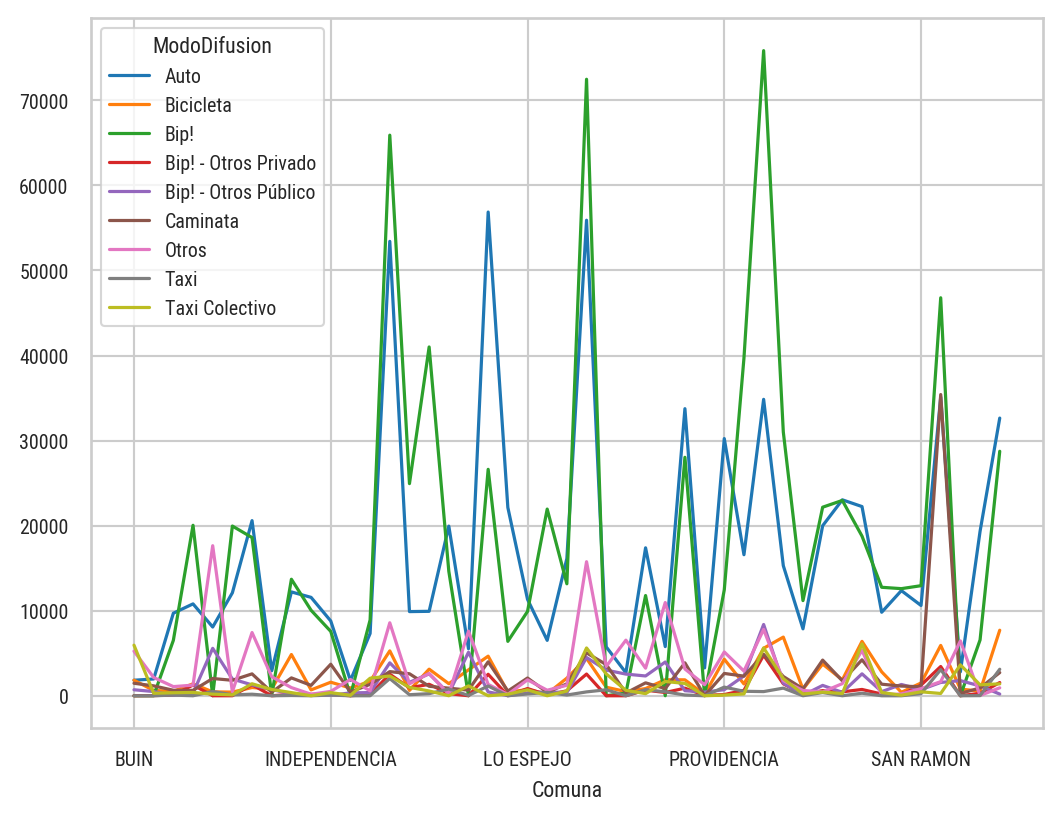

In [16]:
modo_comuna.plot()

No es útil. No respeta lo que hemos visto en clases: utiliza líneas para conectar categorías, pero la pendiente no tiene significado.

<Axes: xlabel='Comuna'>

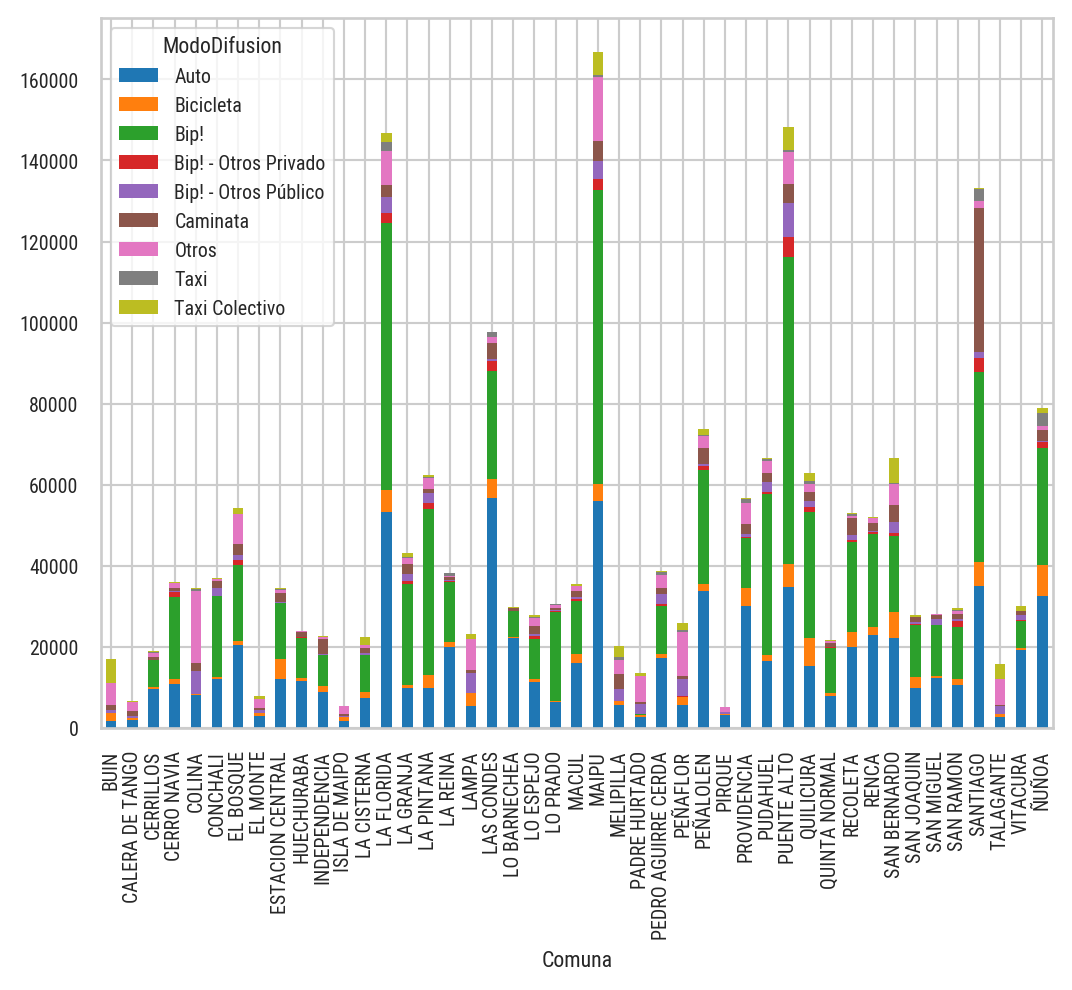

In [17]:
modo_comuna.plot(kind='bar', linewidth=0, stacked=True)

<Axes: ylabel='Comuna'>

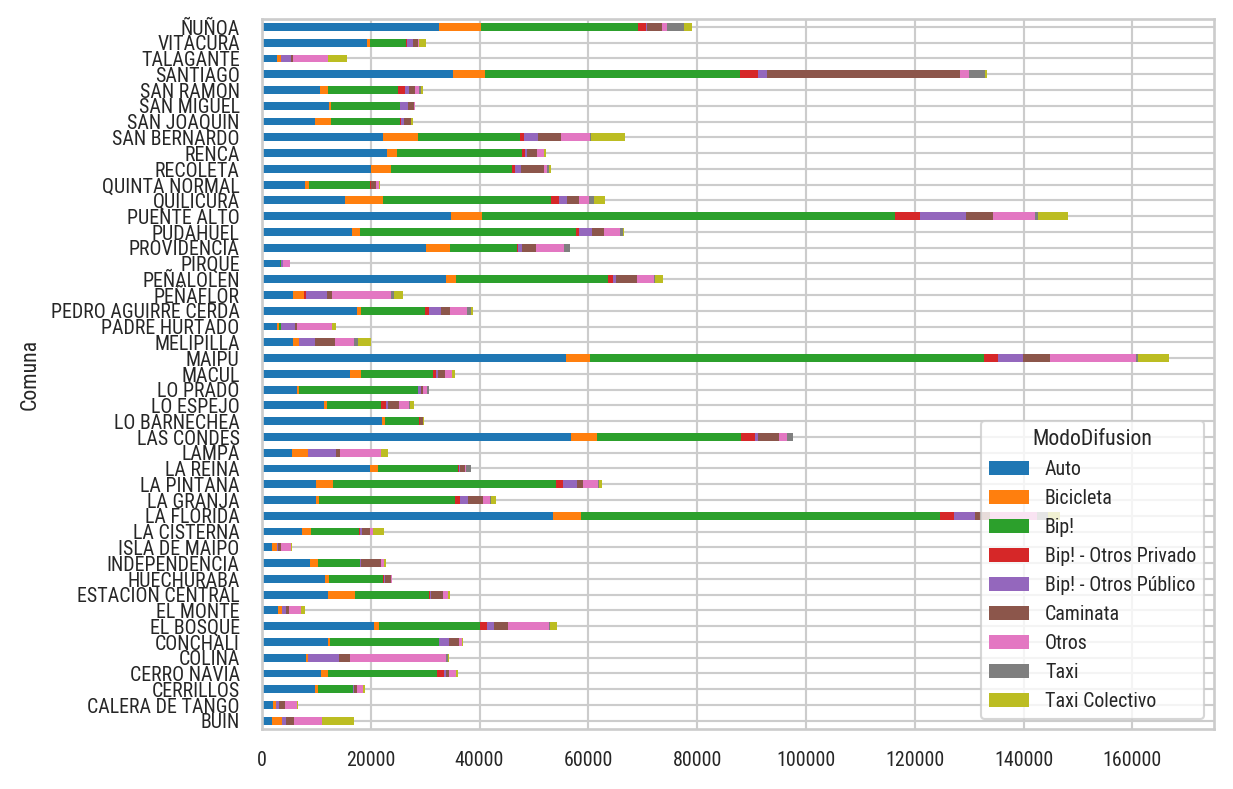

In [18]:
modo_comuna.plot(kind='barh', linewidth=0, stacked=True)

En `aves` tenemos un método `barchart` que hace esto mismo pero de una manera que no oculta el utilizar `matplotlib` (y que, por lo mismo, más adelante veremos que podemos combinar con otros gráficos):

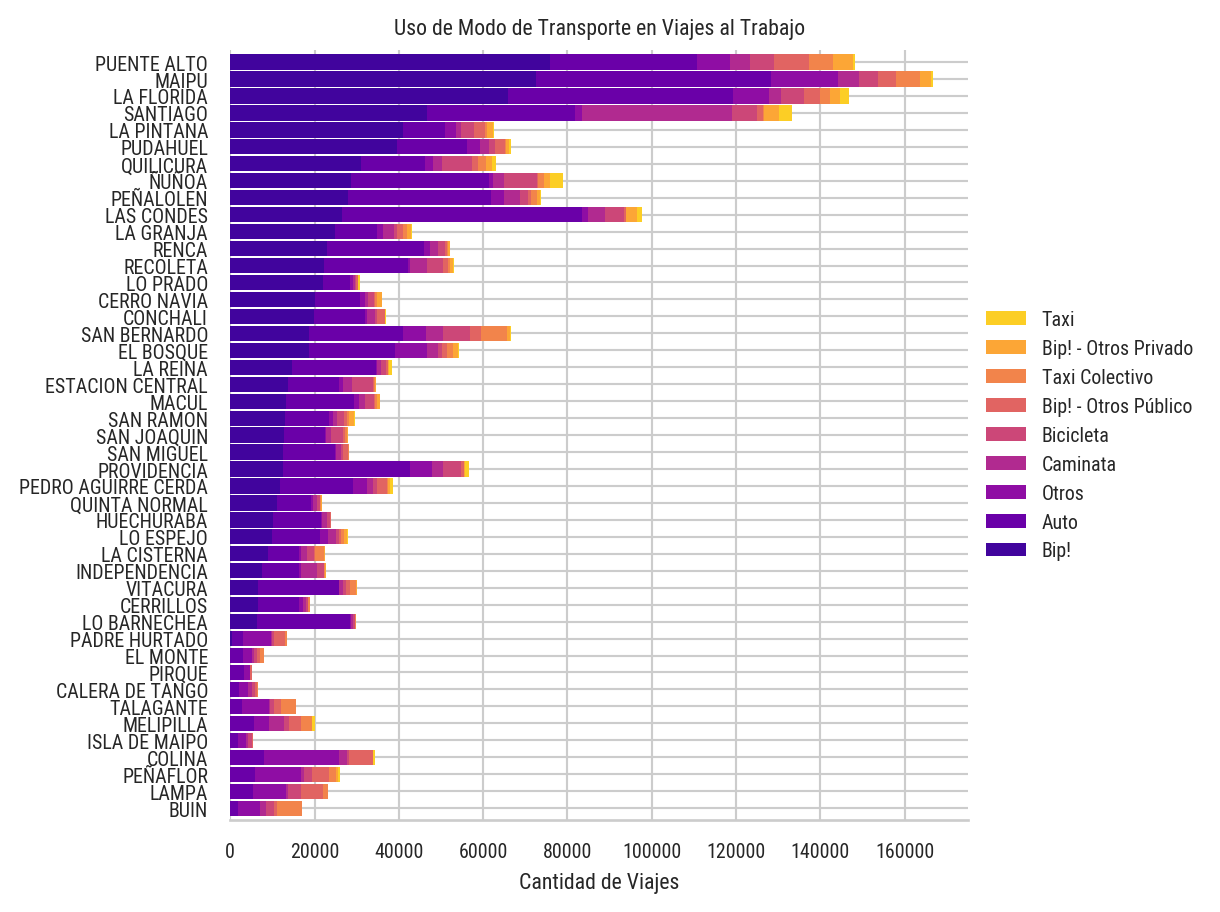

In [19]:
from aves.visualization.tables import barchart

fig, ax = plt.subplots()

barchart(
    ax,
    modo_comuna,
    stacked=True,
    sort_categories=True,
    sort_items=True,
    horizontal=True
)

ax.set_title("Uso de Modo de Transporte en Viajes al Trabajo")
ax.set_ylabel("")
ax.set_xlabel("Cantidad de Viajes")

fig.tight_layout()

¡Es un gráfico interesante! Sin embargo está complejo, ya que cuesta diferenciar y comparar las distintas categorías. Creemos una categorización más sencilla que nos permita comparar mejor:

In [20]:
tabla_completa["ModoAgregado"] = tabla_completa["ModoDifusion"].map(
    {
        "Taxi": "Taxi",
        "Bip! - Otros Privado": "Público",
        "Bip!": "Público",
        "Bip! - Otros Público": "Público",
        "Taxi Colectivo": "Taxi",
        "Bicicleta": "Activo",
        "Caminata": "Activo",
        "Auto": "Auto",
        "Otros": "Otros",
    }
)

modo_comuna = (
    tabla_completa[tabla_completa["Proposito"] == "Al trabajo"]
    .drop_duplicates(subset=["Persona"], keep="first")
    .groupby(["Comuna", "ModoAgregado"])
    ["Peso"].sum()
    .unstack(fill_value=0)
)

modo_comuna

ModoAgregado,Activo,Auto,Otros,Público,Taxi
Comuna,,,,,
BUIN,3294.277879,1824.105716,5239.91868,702.144519,5944.428431
CALERA DE TANGO,1783.448677,1971.629854,2145.95420,509.680586,291.329418
CERRILLOS,1166.230497,9703.874003,1074.40780,6639.630312,426.177568
CERRO NAVIA,2036.498972,10800.115134,1244.83879,21607.777468,387.695813
COLINA,2482.542855,8078.890875,17639.43572,5575.272880,686.994933
CONCHALI,2244.817190,12102.803898,467.36618,21919.623474,208.620739
EL BOSQUE,3536.510313,20587.535364,7429.41043,21176.877856,1586.483217
EL MONTE,1208.206163,2938.497080,2231.74593,787.022475,735.431360
ESTACION CENTRAL,6946.692416,12205.617216,958.13213,14071.505180,400.725164


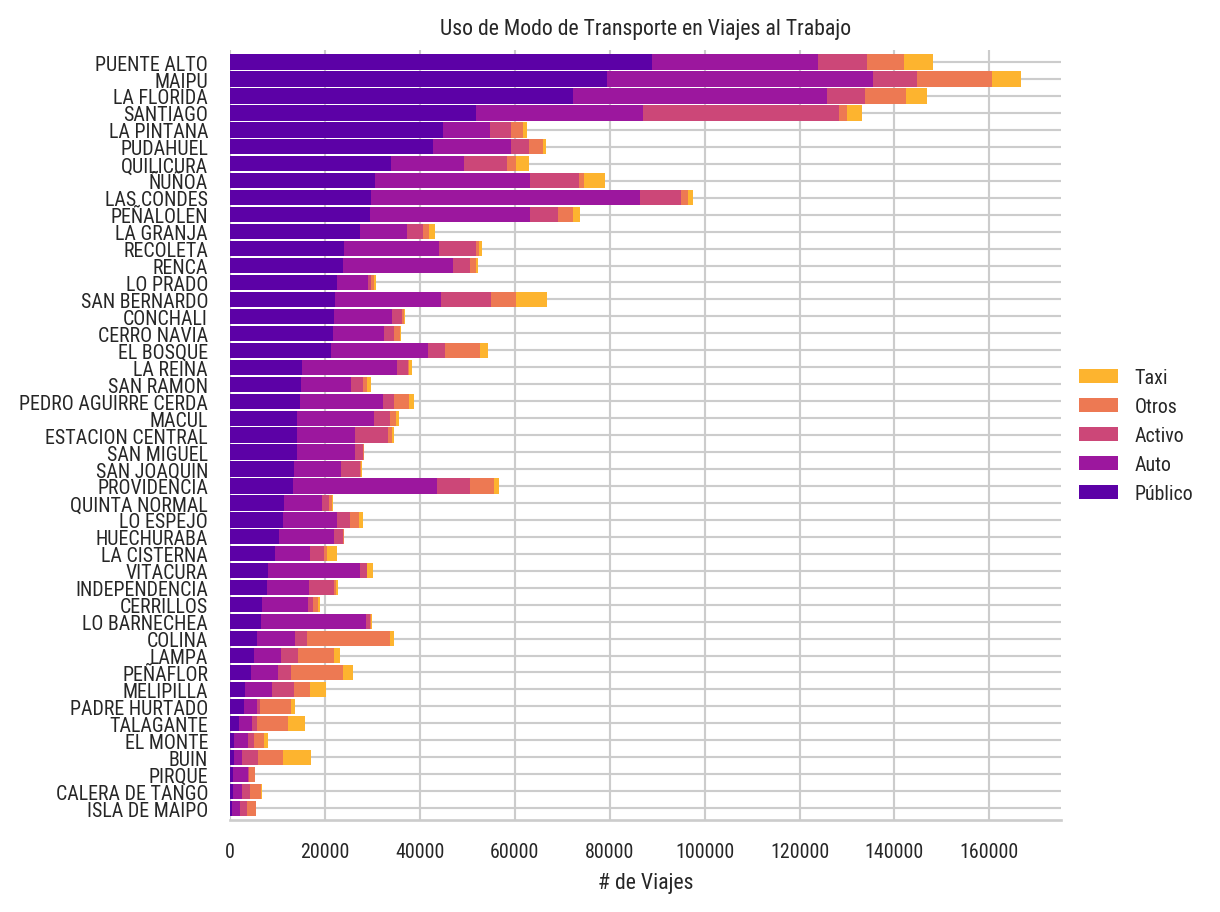

In [21]:
fig, ax = plt.subplots()

barchart(
    ax,
    modo_comuna,
    stacked=True,
    sort_categories=True,
    sort_items=True,
    horizontal=True
)

ax.set_title("Uso de Modo de Transporte en Viajes al Trabajo")
ax.set_ylabel("")
ax.set_xlabel("# de Viajes")

fig.tight_layout()

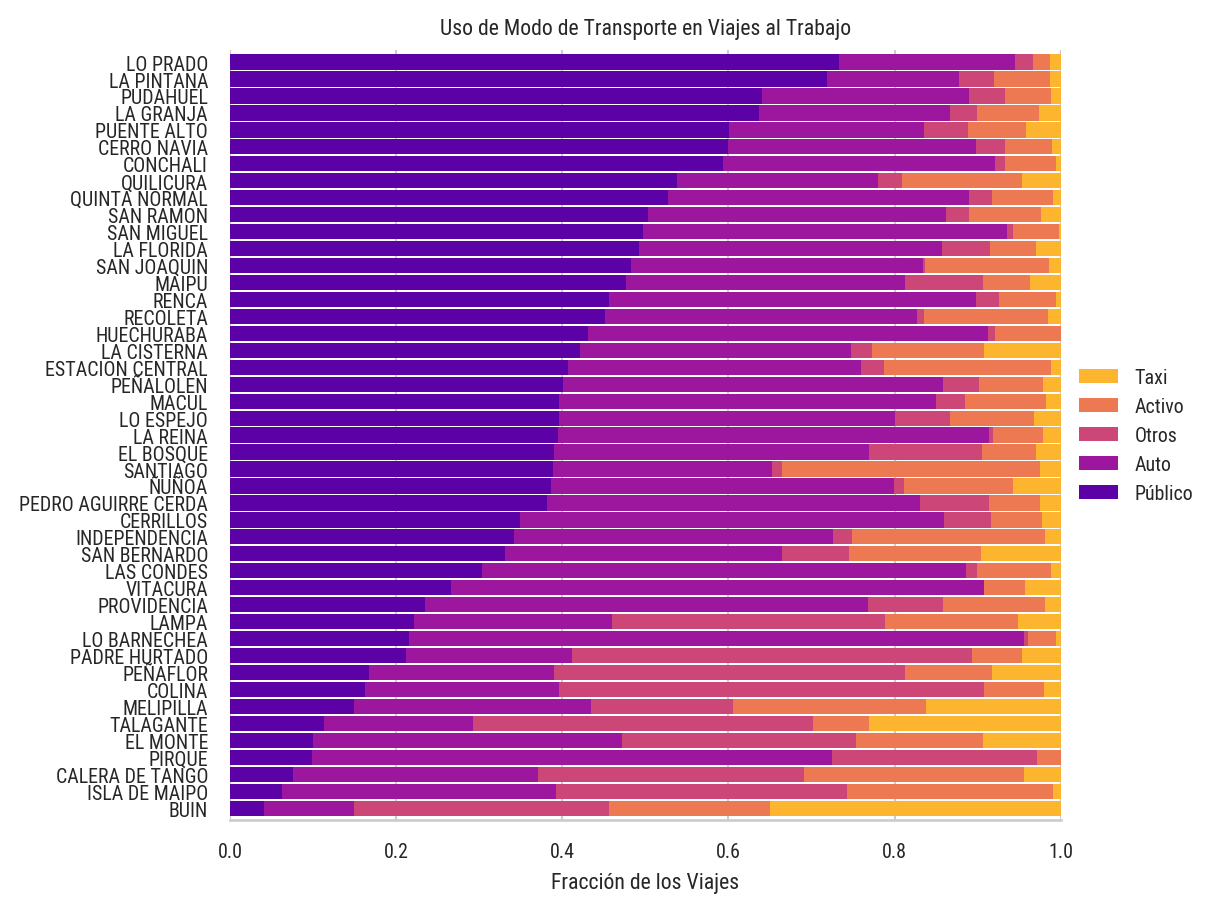

In [22]:
fig, ax = plt.subplots()

barchart(
    ax,
    modo_comuna,
    stacked=True,
    normalize=True,
    sort_categories=True,
    sort_items=True,
    horizontal=True
)

ax.set_title("Uso de Modo de Transporte en Viajes al Trabajo")
ax.set_ylabel("")
ax.set_xlabel("Fracción de los Viajes")

fig.tight_layout()

Verlo nos lleva a preguntarnos si existe una relación entre las propiedades de una comuna y su uso de transporte público.

Para ello calcularemos el ingreso promedio en cada comuna. Al igual que con los viajes, debemos utilizar el ingreso considerando los factores de expansión:

In [23]:
ingreso_por_comuna = (
    hogares.groupby("Comuna")
    .apply(
        lambda x: (x["FactorHogar"] * x["IngresoHogar"]).sum() / x["FactorHogar"].sum()
    )
    .rename("ingreso")
    .astype(int)
)

ingreso_por_comuna.sort_values()


/tmp/ipykernel_5931/2687268991.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(


Comuna
ISLA DE MAIPO           407419
LA PINTANA              419354
CERRO NAVIA             421367
EL MONTE                424736
MELIPILLA               459430
LO PRADO                459634
TALAGANTE               460640
PADRE HURTADO           482747
ESTACION CENTRAL        483239
PEÑAFLOR                484696
SAN BERNARDO            496299
LO ESPEJO               497818
CALERA DE TANGO         505995
SAN JOAQUIN             512128
QUINTA NORMAL           512784
EL BOSQUE               514362
RENCA                   520308
SAN RAMON               523237
CERRILLOS               528750
PUDAHUEL                537591
PEDRO AGUIRRE CERDA     546292
LA GRANJA               559155
PUENTE ALTO             568515
BUIN                    575351
QUILICURA               594006
MAIPU                   595384
CONCHALI                605069
INDEPENDENCIA           605773
LA CISTERNA             616074
RECOLETA                635069
LAMPA                   648293
COLINA                  655243
P

Ahora que tenemos esta serie, podemos hacer un cruce entre las dos tablas que hemos calculado. utilizamos la función `normalize_rows` para normalizar los valores de cada comuna, y así poder compararlas:

In [24]:
from aves.features.utils import normalize_rows

modo_comuna_ingreso = modo_comuna.pipe(normalize_rows).join(ingreso_por_comuna)
modo_comuna_ingreso


,Activo,Auto,Otros,Público,Taxi,ingreso
Comuna,,,,,,
BUIN,0.193725,0.107270,0.308142,0.041291,0.349572,575351
CALERA DE TANGO,0.266105,0.294183,0.320194,0.076049,0.043469,505995
CERRILLOS,0.061347,0.510453,0.056517,0.349265,0.022418,528750
CERRO NAVIA,0.056449,0.299364,0.034505,0.598936,0.010746,421367
COLINA,0.072035,0.234421,0.511835,0.161775,0.019934,655243
CONCHALI,0.060764,0.327605,0.012651,0.593333,0.005647,605069
EL BOSQUE,0.065109,0.379027,0.136779,0.389877,0.029208,514362
EL MONTE,0.152920,0.371919,0.282467,0.099612,0.093082,424736
ESTACION CENTRAL,0.200872,0.352940,0.027706,0.406895,0.011587,483239


Para comparar el uso de transporte público y el ingreso poddemos utilizar un `scatterplot`:

<Axes: xlabel='ingreso', ylabel='Público'>

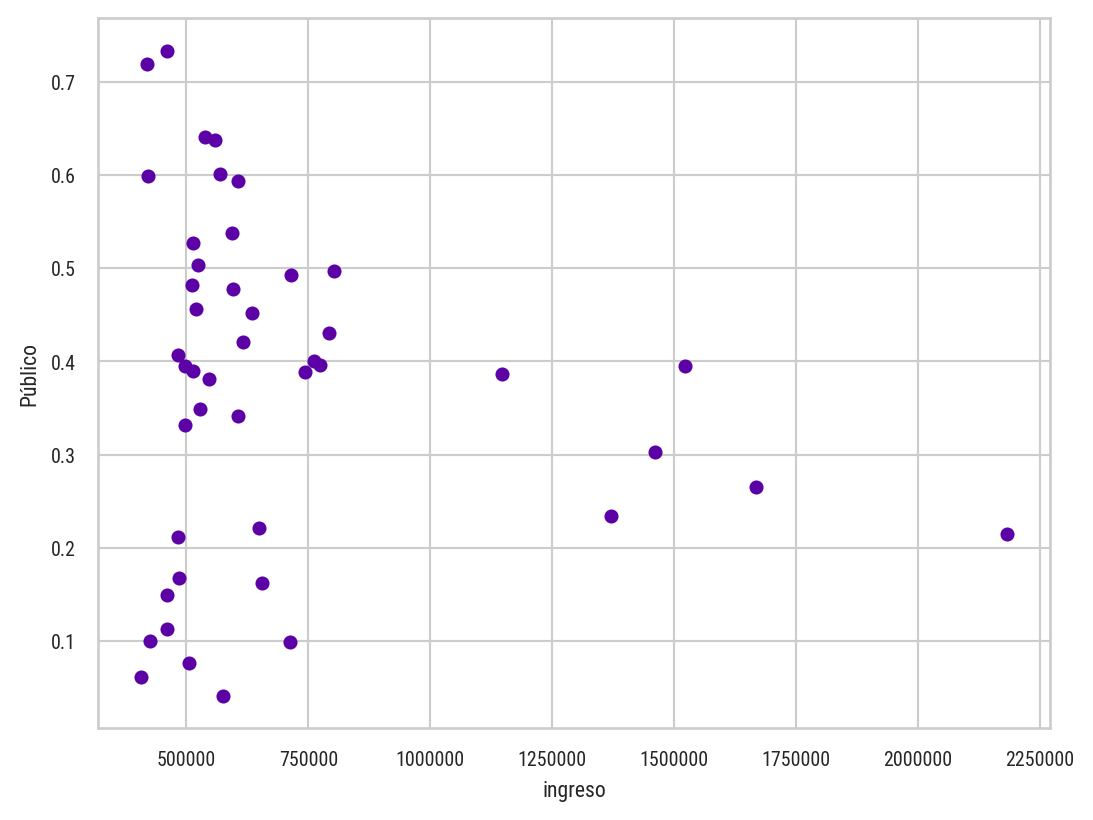

In [25]:
modo_comuna_ingreso.plot(x="ingreso", y="Público", kind="scatter")


Aunque nos gustaría saber cuál es la comuna que corresponde a cada punto, el gráfico no lo dice. Además el eje `x` utiliza una notación que nos impide apreciar los valores totales. Para ello podemos utilizar el método `scatterplot` en aves, en conjunto con configuraciones de matplotlib:

In [26]:
from aves.visualization.tables import scatterplot

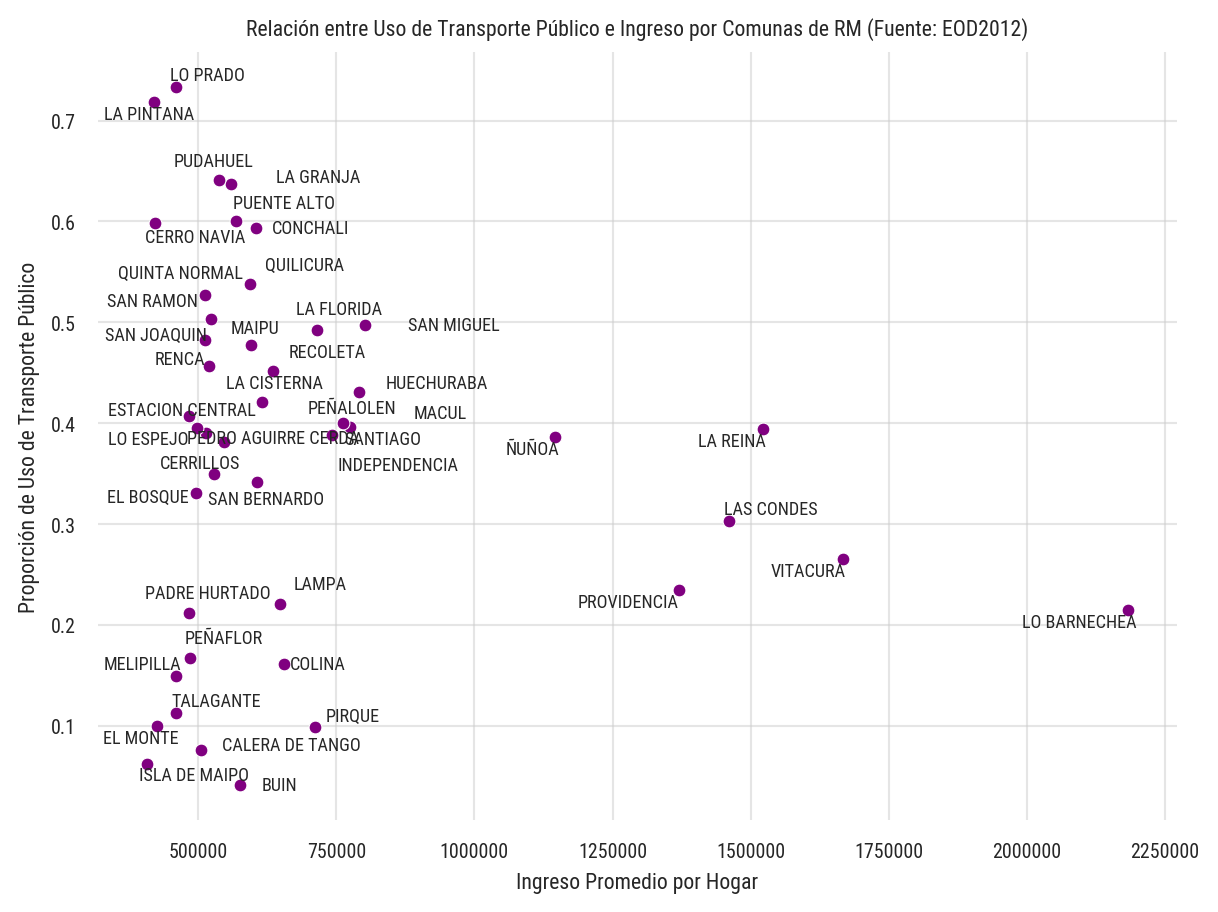

In [27]:
fig, ax = plt.subplots(1, 1)

scatterplot(
    ax,
    modo_comuna_ingreso,
    "ingreso",
    "Público",
    annotate=True,
    avoid_collisions=True,
    label_args=dict(fontsize="small"),
    scatter_args=dict(color="purple"),
)

ax.set_xlabel("Ingreso Promedio por Hogar")
ax.set_ylabel("Proporción de Uso de Transporte Público")
ax.set_title(
    "Relación entre Uso de Transporte Público e Ingreso por Comunas de RM (Fuente: EOD2012)"
)
ax.grid(alpha=0.5)
ax.ticklabel_format(style="plain")

sns.despine(ax=ax, left=True, bottom=True, right=True, top=True)

fig.tight_layout()

Observamos que los tres grupos de uso de transporte público son: las comunas fuera del radio urbano (esquina inferior izquierda), que no son más ricas que el resto y no usan transantiago porque no llega a ellas; las comunas ricas (inferior derecha), que casi no usan transporte público a pesar de estar bien conectadas; y el resto, que presenta tasas variables de uso de transporte público.
  

Vimos en clase el _ternary plot_. Podemos intentar hacer uno, utilizando la biblioteca `python-ternary` (que es parte del entorno de `aves`). Todavía me falta hacer una función dentro de `aves` que la utilice, pero aquí hay un ejemplo de cómo se utiliza:

/home/egraells/miniconda3/envs/aves/lib/python3.11/site-packages/ternary/plotting.py:148: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  ax.scatter(xs, ys, vmin=vmin, vmax=vmax, **kwargs)


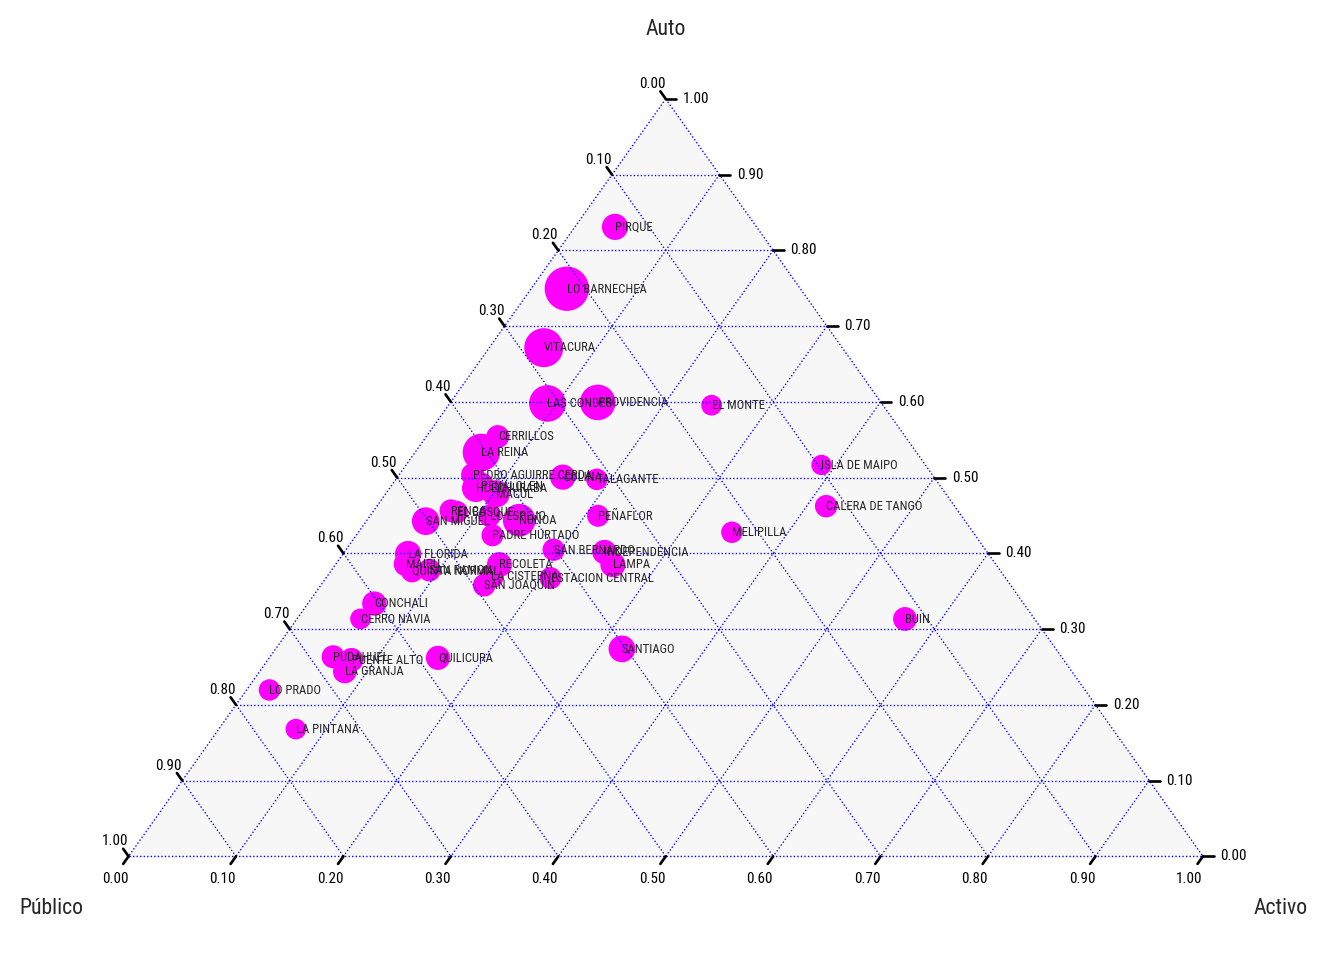

In [28]:
import ternary

# Scatter Plot
scale = 1
fig, tax = ternary.figure(scale=scale)

points = modo_comuna[['Activo', 'Auto', 'Público']].pipe(normalize_rows)
tax.scatter(points.values, s=modo_comuna_ingreso['ingreso'].div(modo_comuna_ingreso['ingreso'].max()) * 1000, marker='.', color='magenta')
tax.right_corner_label(points.columns[0])
tax.top_corner_label(points.columns[1])
tax.left_corner_label(points.columns[2])

texts = []
for idx, row in points.iterrows():
    tax.annotate(idx, row.values, fontsize='xx-small', va='center')
    
tax.gridlines(multiple=0.1, color="blue")
tax.ticks(axis='lbr', linewidth=1, multiple=0.1, tick_formats="%.2f", fontsize='x-small')
tax.clear_matplotlib_ticks()
tax.get_axes().axis('off')

fig.tight_layout()

El resultado es interesante, pero le falta trabajo: ¿cómo etiquetar los ejes para que sean interpretables? ¿Cómo evitar que las etiquetas de los puntos se intersecten? También hace falta incorporar una leyenda que permita saber qué significa el tamaño de los puntos.

## ¿Cuáles son las rutinas en la ciudad?

Para mejorar el funcionamiento de una ciudad es clave entender qué se hace en ella y cuándo.

Sabemos que el qué se hace está codificado en el atributo categórico `Proposito`. También sabemos que el atributo categórico `DiaAsig` se refiere al día que está asignado a la persona que responde la encuesta (al día de sus viajes).

In [29]:
tabla_completa["DiaAsig"]

0           jueves
1        miércoles
2        miércoles
3        miércoles
4        miércoles
           ...    
89770      domingo
89771      domingo
89772      domingo
89773      domingo
89774      domingo
Name: DiaAsig, Length: 89775, dtype: object

Definiremos una rutina como la distribución de viajes por tipo de propósito en cada unidad de análisis (en este caso, un día).

Utilizaremos operaciones `groupby` para calcular esa distribución para cada uno de los días de la semana, en periodo normal.

<Axes: ylabel='Proposito'>

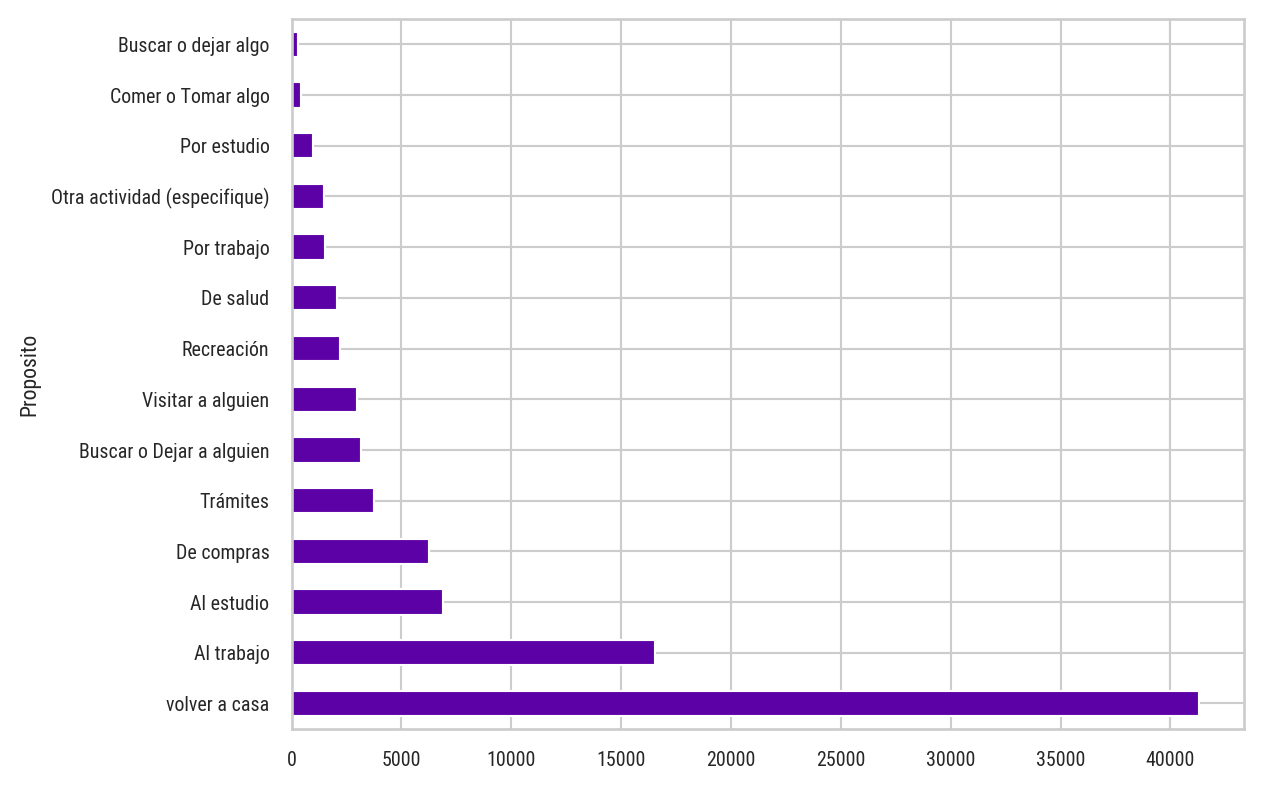

In [30]:
tabla_completa['Proposito'].value_counts().plot(kind='barh')

In [31]:
rutinas = (
    tabla_completa
    .groupby(["DiaAsig", "Proposito"])["Peso"]
    .sum()
    .unstack()
    .loc[["lunes", "martes", "miércoles", "jueves", "viernes", "sábado", "domingo"]]
    # eliminaremos los viajes de volver a casa y de tipo otra actividad porque no ayudan a caracterizar las rutinas diarias.
    .drop(["volver a casa", "Otra actividad (especifique)"], axis=1)
)

rutinas


Proposito,Al estudio,Al trabajo,Buscar o Dejar a alguien,Buscar o dejar algo,Comer o Tomar algo,De compras,De salud,Por estudio,Por trabajo,Recreación,Trámites,Visitar a alguien
DiaAsig,,,,,,,,,,,,
lunes,159003.124730,316293.367568,73132.456932,7225.954498,12074.071123,87770.634957,39473.197185,16248.692482,34783.629175,25122.870724,69121.083701,31593.338060
martes,170418.216912,392105.356594,85853.573248,4699.525999,14531.431494,108246.518137,40470.004240,17872.622108,39718.728270,33942.625074,83657.821650,44079.909840
miércoles,192808.994565,455178.199176,88040.091838,9134.021504,21738.399054,161290.716078,66730.618650,19108.975964,70502.145352,33300.823836,98600.791569,64406.954252
jueves,180444.642104,406452.299525,114397.466184,5524.044901,10838.657163,135551.782058,46559.225899,14967.667016,49297.748485,35870.969056,85694.082985,54645.048105
viernes,222546.924573,443611.632080,108072.448233,9513.543380,15657.148023,163396.700716,45079.394977,22096.329992,57534.860535,58698.092712,105577.043480,71279.013897
sábado,6549.929735,123932.530076,22919.866404,4753.552588,5512.512097,159191.084196,12927.596680,6425.900982,14139.914461,80059.006877,26199.539858,67644.087697
domingo,1365.568649,80954.738533,18031.754010,2107.011594,6596.475800,174561.769601,6744.770941,6860.201348,14105.297866,93984.526573,27759.660943,100227.499379


¿Cómo visualizar esta tabla? Una manera directa es utilizar el método `plot` de pandas, que usará un `linechart`. Veamos como luce:

<Axes: xlabel='DiaAsig'>

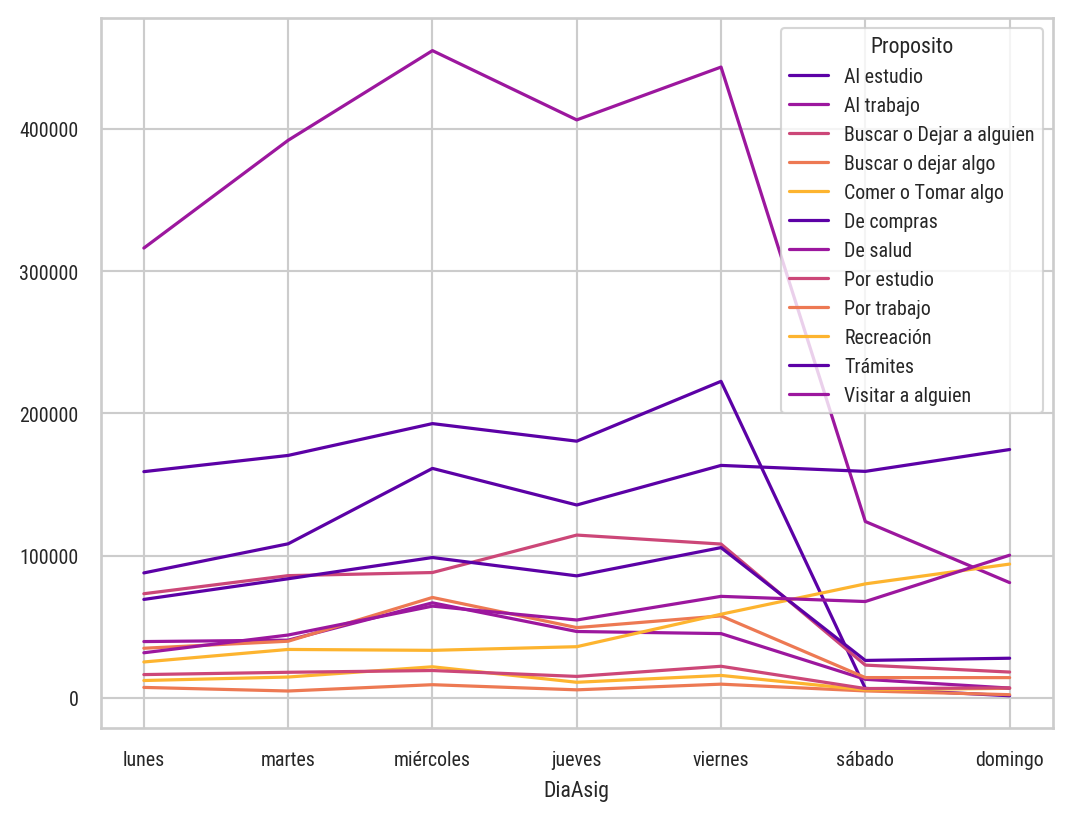

In [32]:
rutinas.plot()


No se ve bonito, pero tampoco configuramos nada del gráfico, solamente lo ejecutamos para tener una noción de cómo se verían los datos. 

A pesar de que podríamos utilizar líneas, ya que la progresión de lunes a domingo es ordinal y puede ser interpolada, no tiene un significado relevante para nosotros de acuerdo a la definición de rutina. Además la cantidad de categorías en los datos hace difícil distinguir una línea de otra.

Podemos hacer la misma exploración, esta vez con un `barchart`:

Ahora bien, ¿buscamos es identificar patrones relativos? En tal caso, podemos probar con un gráfico normalizado:

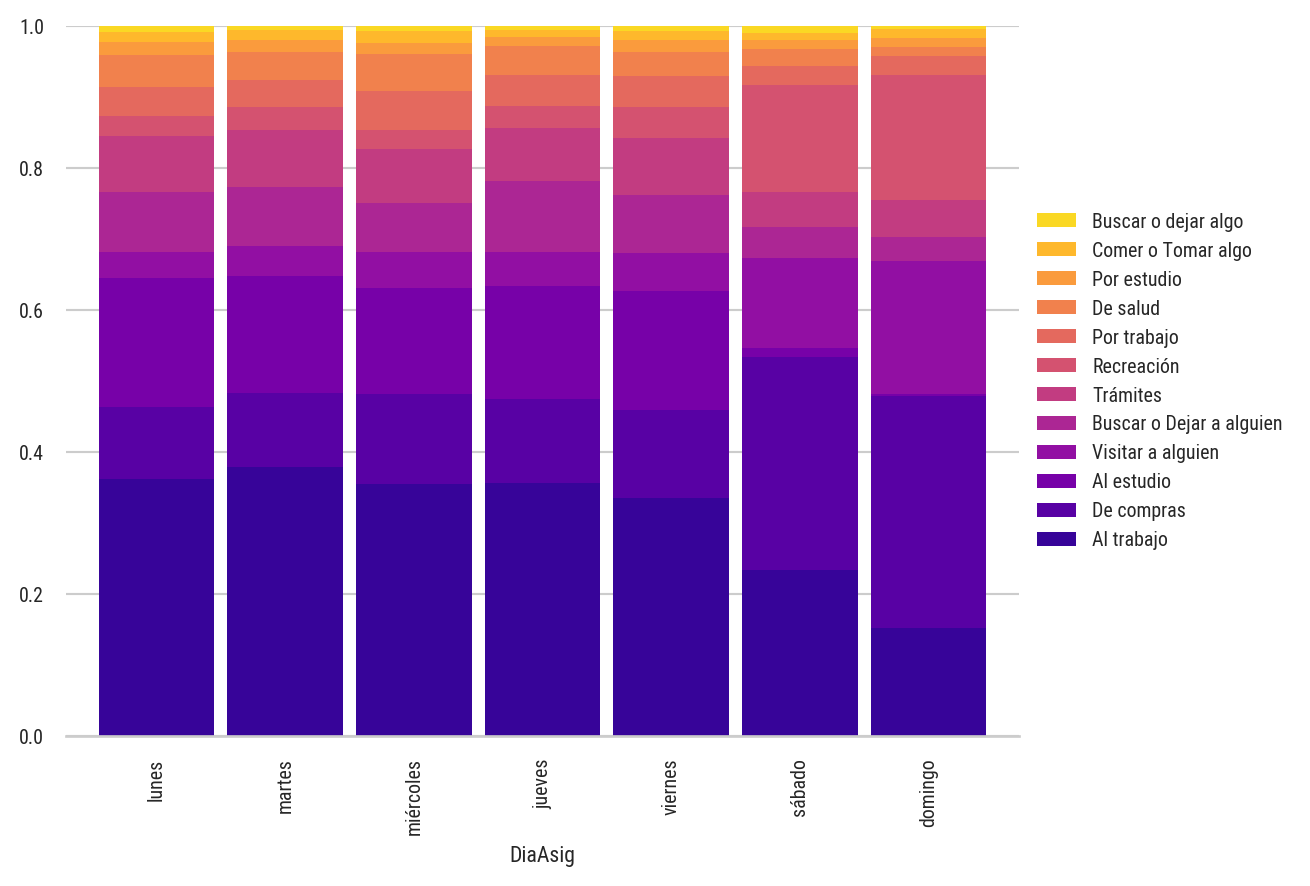

In [33]:
fig, ax = plt.subplots()
barchart(ax, rutinas, stacked=True, normalize=True, sort_categories=True)


Al usar un gráfico relativo encontramos diferencias que antes no parecían tan notorias. Por ejemplo, en proporción, los viajes de recreación son más frecuentes los fines de semana que de lunes a viernes. En el gráfico absoluto se notaba un ligero incremento, pero quizás lo interesante es que, así como suben los de recreación, bajan mucho los demás. 

Lo mismo sucede con visitar a alguien e ir de compras.

El gráfico de barras podría ser suficiente si lo que queremos es determinar si hay diferencias entre las rutinas. Con esta última versión, sabemos que son diferentes, y tenemos una noción de cuáles son las diferencias.

Sin embargo, si nuestra tarea consistiese en identificar elementos específicos de las rutinas, como puede ser _conocer los valores exactos de la distribución_, o _agrupar actividades de acuerdo a su distribución en varios días_, entonces debemos buscar otra alternativa.

Exploremos como luce un heatmap en este caso:

<Axes: xlabel='Proposito', ylabel='DiaAsig'>

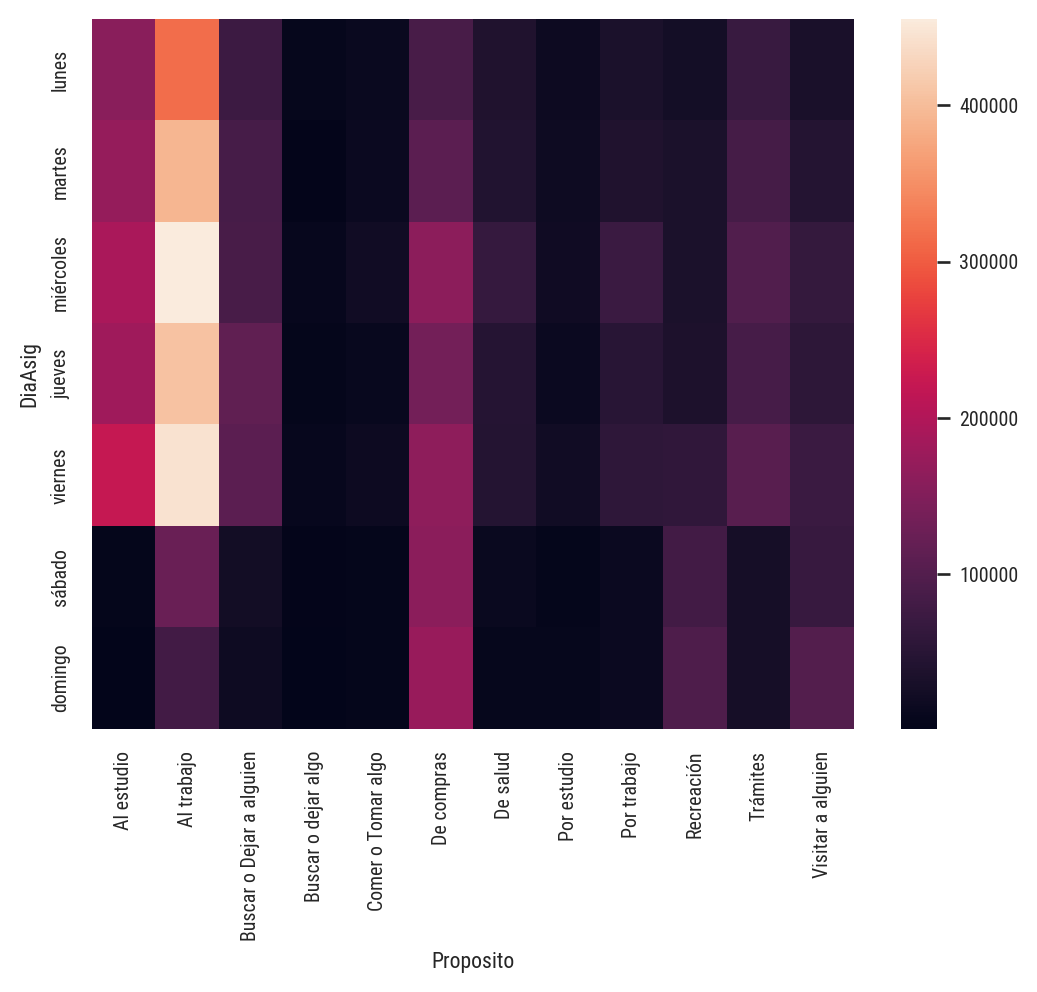

In [34]:
import seaborn as sns

sns.heatmap(rutinas)


Lo que hicimos en el gráfico de barras fue normalizar las columnas de la tabla. Podemos hacer lo mismo. Y luego trasponerla para facilitar la lectura. Quedaría así:

<Axes: xlabel='DiaAsig', ylabel='Proposito'>

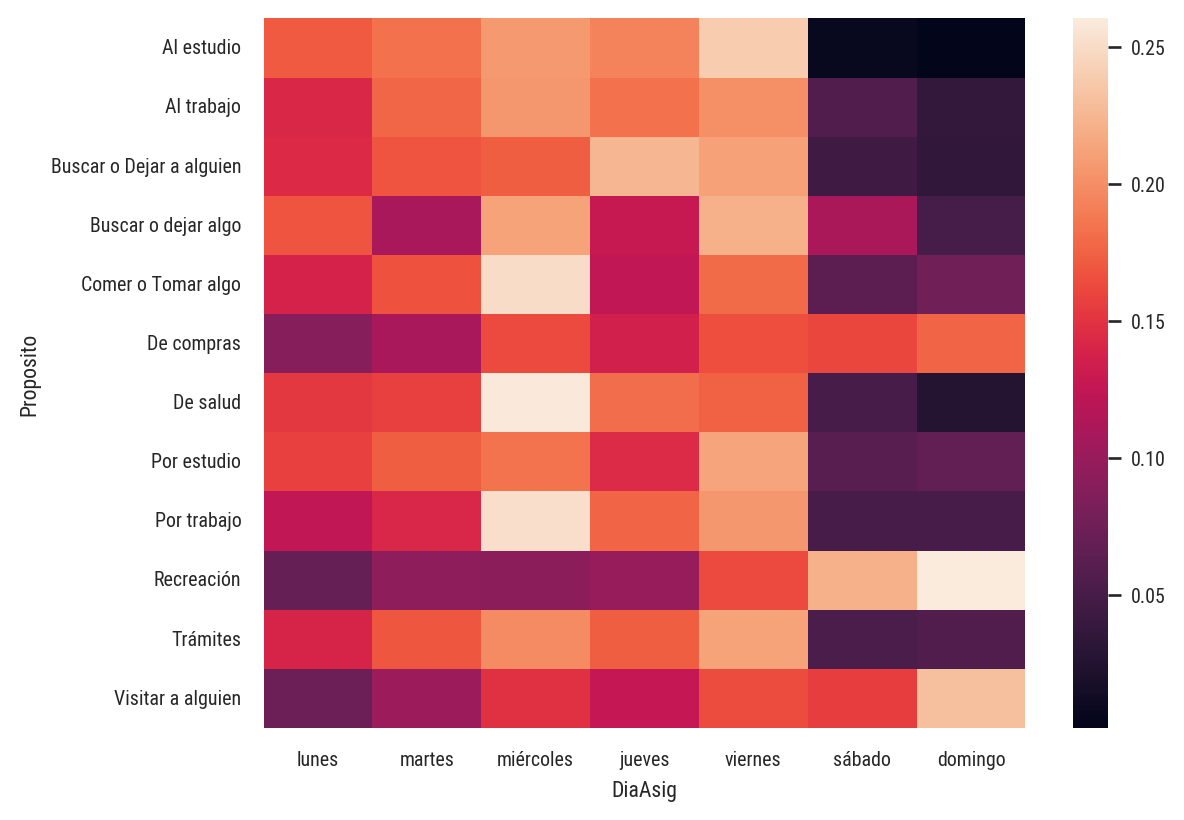

In [35]:
sns.heatmap(rutinas.pipe(normalize_columns).T)


Observamos que este heatmap nos permite apreciar las variaciones diarias en la proporción. Si lo configuramos para que muestre más información y tenga mejor apariencia podría ser el gráfico final de la tarea:

Text(0.5, 1.0, 'Rutinas Diarias en Santiago')

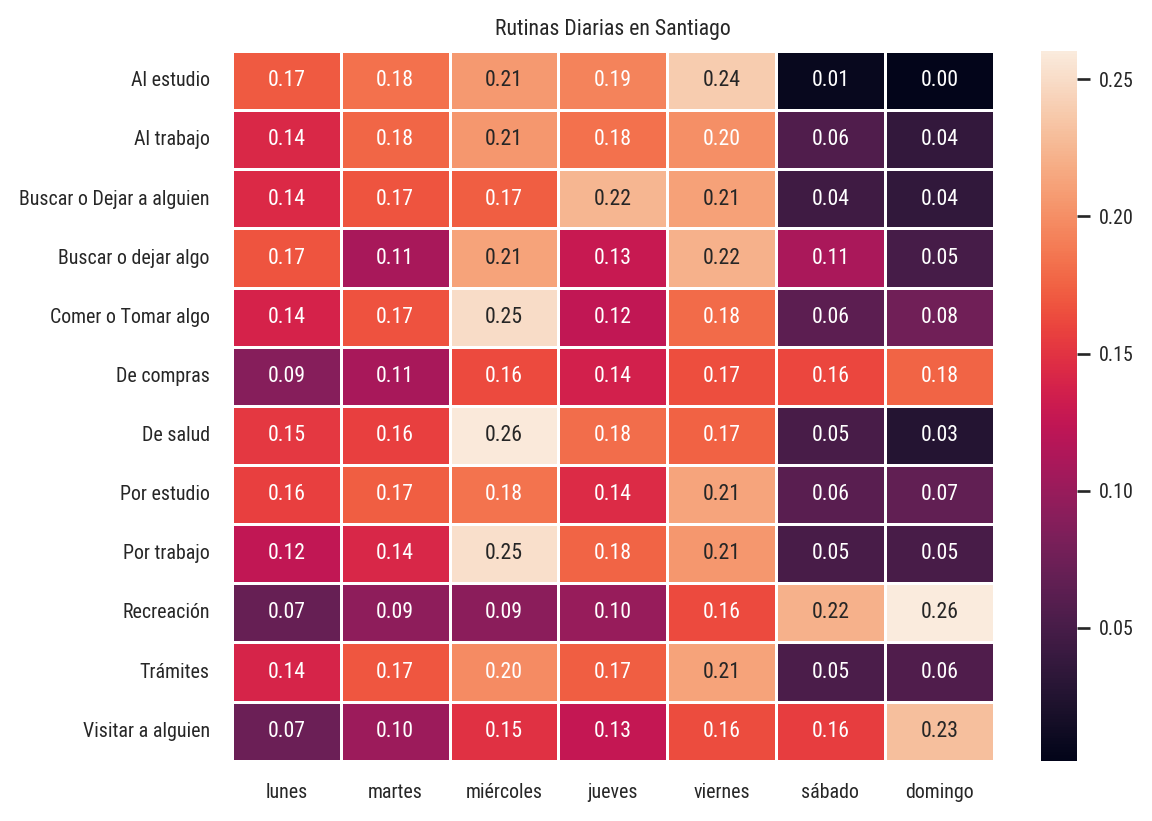

In [36]:
fig, ax = plt.subplots()

sns.heatmap(
    rutinas.pipe(normalize_columns).T,
    ax=ax,
    annot=True,
    fmt=".2f",
    linewidth=0.5,
)

ax.set_ylabel("")
ax.set_xlabel("")
ax.set_title("Rutinas Diarias en Santiago")


Ese gráfico ya está terminado: podemos ver patrones globales gracias a la escala de colores, y podemos comparar e identificar valores específicos gracias a las anotaciones.

Todavía nos falta poder agrupar las actividades (o filas de la matriz) de acuerdo a su similitud. Afortunadamente lo podemos lograr cambiando el método empleado: usar un `clustermap` en vez de un `heatmap`:

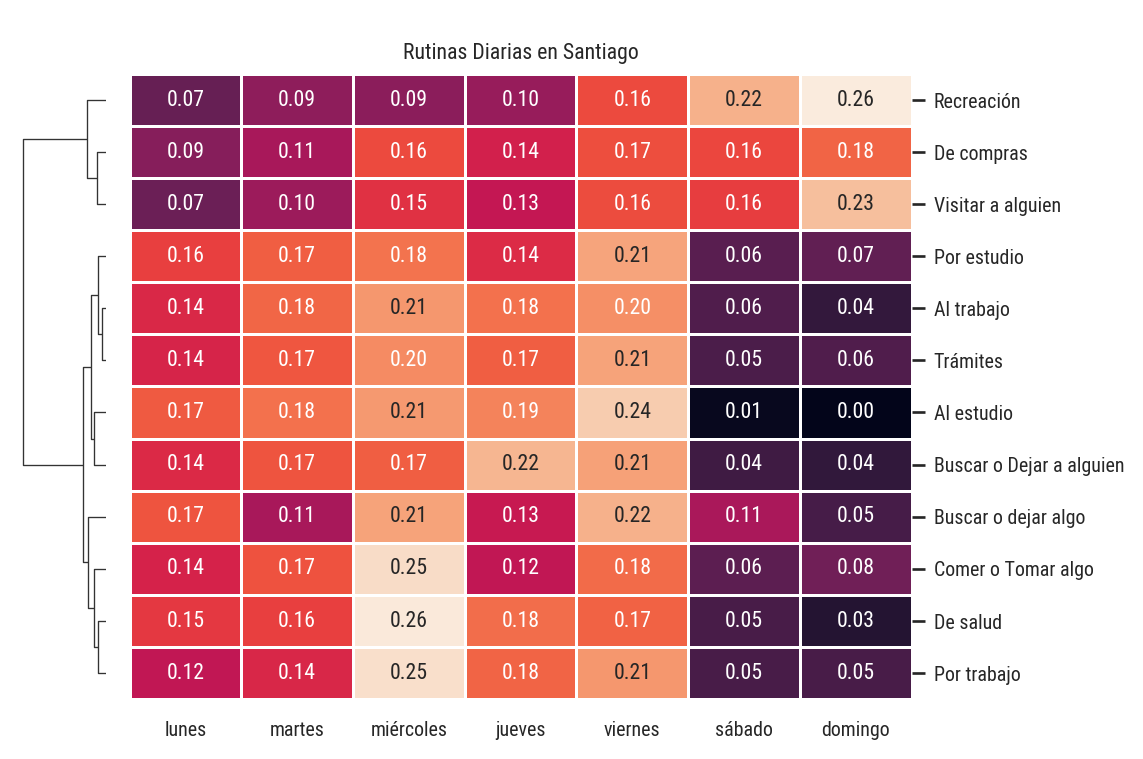

In [37]:
grid = sns.clustermap(
    rutinas.pipe(normalize_columns).T,
    col_cluster=False,
    annot=True,
    figsize=(6,4),
    fmt=".2f",
    linewidth=0.5,
    dendrogram_ratio=[0.1, 0.0],
    method="ward"
)

grid.ax_cbar.set_visible(False)
# grid.ax_heatmap

grid.ax_heatmap.set_ylabel("")
grid.ax_heatmap.set_xlabel("")
grid.ax_heatmap.set_title("Rutinas Diarias en Santiago")

grid.fig.tight_layout()


## ¿Son diferentes las rutinas entre hombres y mujeres? (_lollipop_: un gráfico no visto)

Una primera aproximación es mirar la cantidad de viajes.

In [38]:
from aves.features.utils import weighted_mean

In [39]:
tabla_completa['FactorPersona']

0        53.39174
1        46.32137
2        46.32137
3        43.02566
4        43.02566
           ...   
89770    17.87670
89771    15.34897
89772    15.34897
89773    17.30931
89774    17.30931
Name: FactorPersona, Length: 89775, dtype: float64

/tmp/ipykernel_5931/3177837193.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  personas.groupby("Sexo").apply(


<Axes: ylabel='Viajes'>

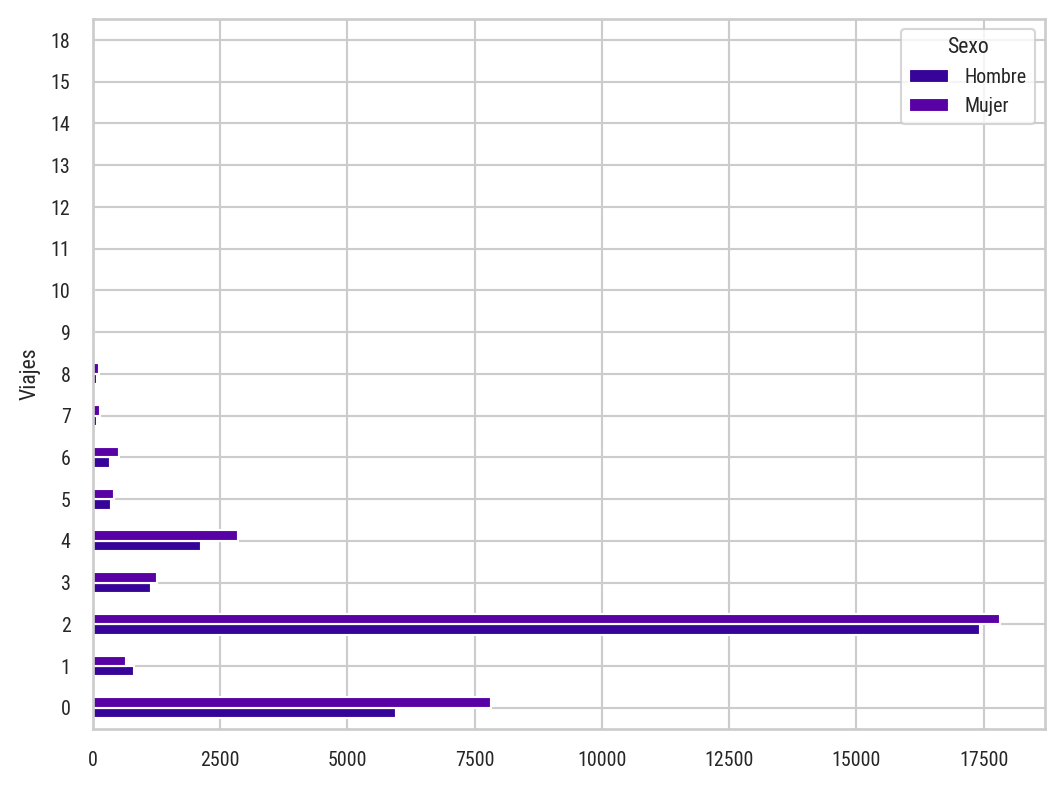

In [40]:
personas.groupby("Sexo").apply(
    lambda x: x["Viajes"].value_counts().sort_index()
).unstack(fill_value=0).T.plot(kind="barh")

In [41]:
personas['Viajes'].mean(), weighted_mean(personas, 'Viajes', 'FactorPersona')

(1.8769940386985047, 1.9589774895693695)

In [42]:
viajes_por_sexo = (
    personas.merge(hogares)
    .groupby(["Sexo", "Sector"])
    .apply(lambda x: weighted_mean(x, "Viajes", "FactorPersona"))
    .unstack()
    .T
)
viajes_por_sexo

/tmp/ipykernel_5931/644985014.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: weighted_mean(x, "Viajes", "FactorPersona"))


Sexo,Hombre,Mujer
Sector,,
Centro,1.941364,1.892221
Extensión Sur-Poniente,1.749888,1.644674
Norte,1.876654,1.806307
Oriente,2.694165,2.497469
Poniente,1.870915,1.958558
Sur,1.937255,1.959056
Sur-Oriente,1.745818,1.716820


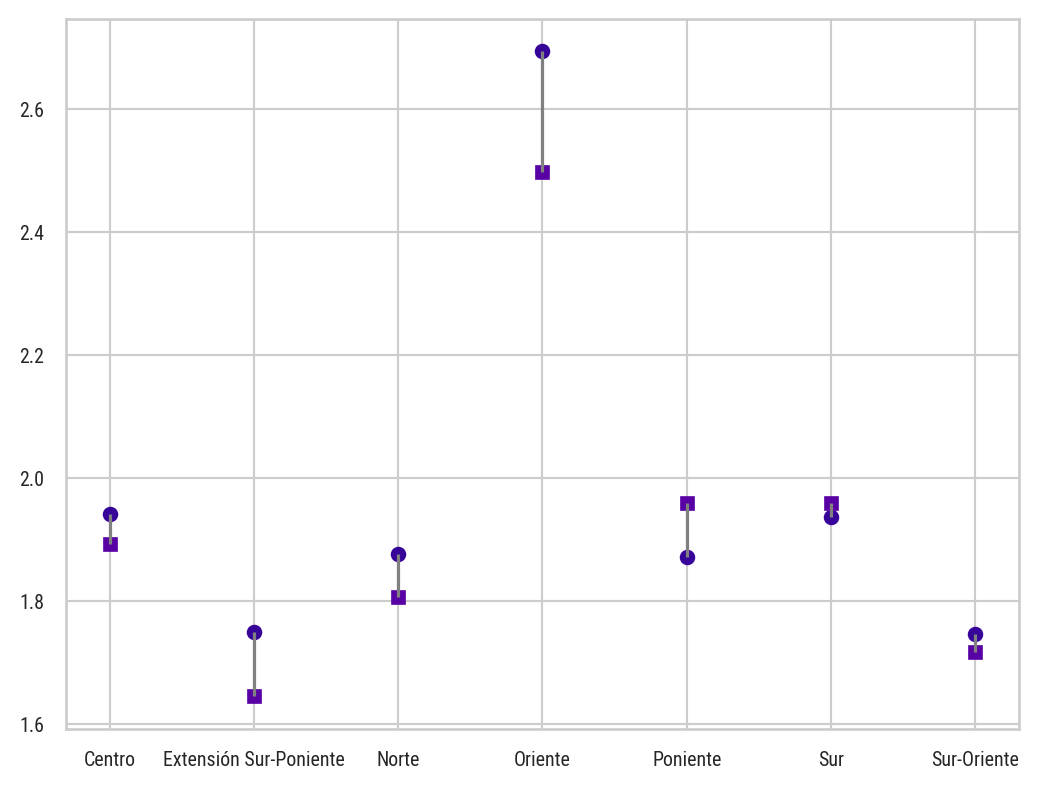

In [43]:
fig, ax = plt.subplots()

ax.plot(viajes_por_sexo['Hombre'], marker='o', linestyle='none')
ax.plot(viajes_por_sexo['Mujer'], marker='s', linestyle='none')
ax.vlines(x=viajes_por_sexo.index, ymin=viajes_por_sexo['Hombre'], ymax=viajes_por_sexo['Mujer'], color='grey')

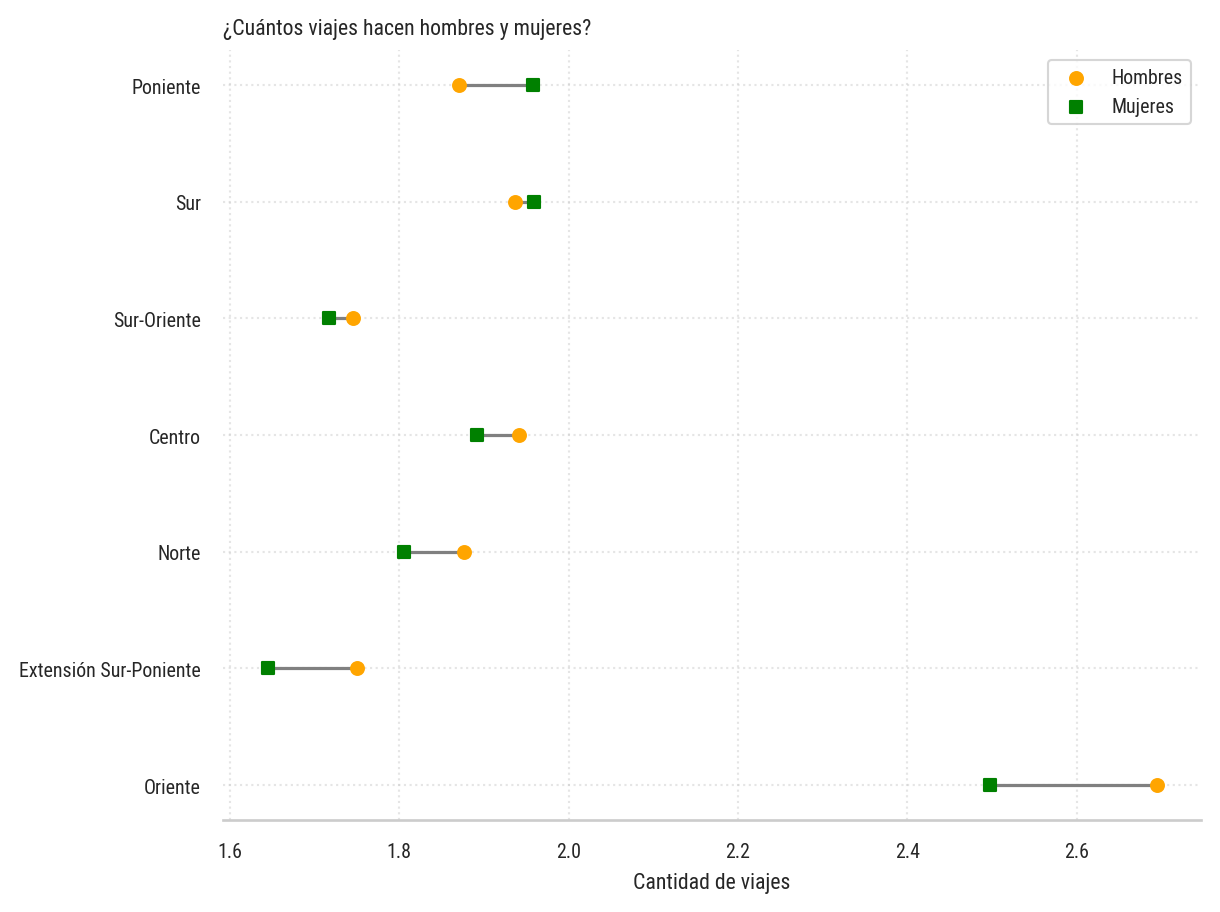

In [44]:
fig, ax = plt.subplots()

plot_df = viajes_por_sexo
plot_df = viajes_por_sexo.assign(diff=lambda x: x['Mujer'] - x['Hombre']).sort_values('diff')

plot_index = range(len(plot_df))

ax.scatter(x=plot_df['Hombre'], y=plot_index, marker='o', label='Hombres', color='orange', zorder=2)
ax.scatter(x=plot_df['Mujer'], y=plot_index, marker='s', label='Mujeres', color='green', zorder=2)
ax.hlines(y=plot_index, xmin=plot_df['Hombre'], xmax=plot_df['Mujer'], color='grey', zorder=1)

ax.set_yticks(plot_index, labels=plot_df.index)
ax.grid(linestyle='dotted', alpha=0.5, zorder=0)

ax.legend()

sns.despine(ax=ax, left=True)
ax.set_title('¿Cuántos viajes hacen hombres y mujeres?', loc='left')
ax.set_xlabel('Cantidad de viajes')

fig.tight_layout()

## ¿Qué hacen las personas durante el día?

Inspirándonos en el ejemplo de visualización del New York Times sobre cómo son los días de las personas, nos preguntamos: **¿Qué hacen las personas durante el día?** Podemos aproximarlo utilizando los datos de la encuesta. Para ello tendremos que calcular para cada minuto del día qué está haciendo cada persona y calcular la distribución por minuto.

Tenemos todo lo necesario: la hora de inicio del viaje `HoraIni`, su duración `TiempoViaje` (en minutos) y el `Proposito`. Necesitaremos lo siguiente de pandas:

* La clase `Timedelta` y las funciones `to_timedelta` y `timedelta_range` para ayudarnos a calcular lo que está haciendo una persona.
* `shift` para combinar una celda con la previa/siguiente, de modo de poder determinar las actividades.

Tendremos una versión incompleta y queda propuesto para ustedes completarla y extender su análisis.

Primero, es necesario construir una tabla de actividades. Una actividad es lo que sucede _después_ del viaje, es el motivo por el que se realiza un viaje. Como tenemos viajes, debemos construir las actividades a partir de ellos.

In [45]:
tabla_completa.columns

Index(['Hogar', 'Persona', 'Viaje', 'Etapas', 'ComunaOrigen', 'ComunaDestino',
       'SectorOrigen', 'SectorDestino', 'ZonaOrigen', 'ZonaDestino',
       'OrigenCoordX', 'OrigenCoordY', 'DestinoCoordX', 'DestinoCoordY',
       'Proposito', 'PropositoAgregado', 'ActividadDestino', 'MediosUsados',
       'ModoAgregado', 'ModoPriPub', 'ModoMotor', 'HoraIni', 'HoraFin',
       'HoraMedia', 'TiempoViaje', 'TiempoMedio', 'Periodo', 'MinutosDespues',
       'CuadrasDespues', 'FactorLaboralNormal', 'FactorSabadoNormal',
       'FactorDomingoNormal', 'FactorLaboralEstival',
       'FactorFindesemanaEstival', 'CodigoTiempo', 'ModoDifusion',
       'DistEuclidiana', 'DistManhattan', 'Imputada', 'TipoDia',
       'FactorExpansion', 'AnoNac', 'Sexo', 'Relacion', 'Viajes',
       'LicenciaConducir', 'PaseEscolar', 'AdultoMayor', 'Estudios', 'Curso',
       'Actividad', 'Ocupacion', 'ActividadEmpresa', 'JornadaTrabajo',
       'DondeEstudia', 'DirActividadCoordX', 'DirActividadCoordY',
       'DirEs

In [46]:
tabla_completa['TipoDia']

0        Laboral
1        Laboral
2        Laboral
3        Laboral
4        Laboral
          ...   
89770    Domingo
89771    Domingo
89772    Domingo
89773    Domingo
89774    Domingo
Name: TipoDia, Length: 89775, dtype: object

In [47]:
tabla_actividades = tabla_completa[['Persona', 'Proposito', 'HoraIni', 'TiempoViaje', 'Peso', 'TipoDia']]
tabla_actividades

,Persona,Proposito,HoraIni,TiempoViaje,Peso,TipoDia
0,17343102,volver a casa,0 days 22:30:00,70.0,53.391740,Laboral
1,17344101,Al trabajo,0 days 13:00:00,105.0,52.214368,Laboral
2,17344101,volver a casa,0 days 22:00:00,90.0,52.214368,Laboral
3,17344103,Al trabajo,0 days 09:00:00,55.0,48.499378,Laboral
4,17344103,volver a casa,0 days 19:00:00,150.0,45.295847,Laboral
...,...,...,...,...,...,...
89770,70679101,volver a casa,0 days 12:40:00,8.0,26.495127,Domingo
89771,74381301,De compras,0 days 10:30:00,15.0,22.748768,Domingo
89772,74381301,volver a casa,0 days 12:00:00,15.0,22.748768,Domingo
89773,74381302,De compras,0 days 10:30:00,5.0,25.654196,Domingo


In [48]:
tabla_actividades.describe()

,Persona,HoraIni,TiempoViaje,Peso
count,8.977500e+04,89775,89647.000000,89774.000000
mean,1.911238e+07,0 days 13:26:54.095238095,42.436044,143.370645
std,5.361221e+06,0 days 04:45:57.368932602,36.843043,254.588292
min,1.000200e+07,0 days 00:00:00,0.000000,0.431389
25%,1.472900e+07,0 days 09:00:00,20.000000,35.609635
50%,1.897230e+07,0 days 13:30:00,30.000000,67.717904
75%,2.347010e+07,0 days 17:30:00,60.000000,143.157649
max,7.438130e+07,0 days 23:59:00,1335.000000,4612.974967


In [49]:
tabla_actividades = tabla_actividades[tabla_actividades['TiempoViaje'] <= 120]
len(tabla_actividades)

87778

Conocemos la hora de término de un viaje. Esa es la hora de inicio de la actividad. Pero, ¿la hora de fin? Esa depende de la siguiente fila en la tabla. Para ello nos servirá el método `shift`.

In [50]:
tabla_actividades.shift(-1)

,Persona,Proposito,HoraIni,TiempoViaje,Peso,TipoDia
0,17344101.0,Al trabajo,0 days 13:00:00,105.0,52.214368,Laboral
1,17344101.0,volver a casa,0 days 22:00:00,90.0,52.214368,Laboral
2,17344103.0,Al trabajo,0 days 09:00:00,55.0,48.499378,Laboral
3,17345101.0,Visitar a alguien,0 days 10:00:00,60.0,51.381489,Domingo
5,17345101.0,volver a casa,0 days 15:00:00,45.0,51.381489,Domingo
...,...,...,...,...,...,...
89770,74381301.0,De compras,0 days 10:30:00,15.0,22.748768,Domingo
89771,74381301.0,volver a casa,0 days 12:00:00,15.0,22.748768,Domingo
89772,74381302.0,De compras,0 days 10:30:00,5.0,25.654196,Domingo
89773,74381302.0,volver a casa,0 days 12:00:00,15.0,25.654196,Domingo


In [51]:
ejemplo = (
    tabla_actividades.join(tabla_actividades.add_prefix("post_").shift(-1))
    .pipe(lambda x: x[x["Persona"] == x["post_Persona"]])
    .drop(
        ["Persona", "post_Persona", "post_TiempoViaje", "post_Peso", "post_Proposito", 'post_TipoDia'],
        axis=1,
    )
    .rename({"post_HoraIni": "fin_actividad"}, axis=1)
    .assign(fin_actividad=lambda x: x["fin_actividad"].round("5min"))
)

ejemplo

,Proposito,HoraIni,TiempoViaje,Peso,TipoDia,fin_actividad
1,Al trabajo,0 days 13:00:00,105.0,52.214368,Laboral,0 days 22:00:00
5,Visitar a alguien,0 days 10:00:00,60.0,51.381489,Domingo,0 days 15:00:00
7,Buscar o Dejar a alguien,0 days 07:50:00,30.0,61.966798,Laboral,0 days 08:30:00
8,Al trabajo,0 days 08:30:00,10.0,61.966798,Laboral,0 days 17:20:00
9,Buscar o Dejar a alguien,0 days 17:20:00,10.0,88.048666,Laboral,0 days 17:40:00
...,...,...,...,...,...,...
89765,Trámites,0 days 11:00:00,50.0,85.893672,Domingo,0 days 14:00:00
89767,Al trabajo,0 days 12:00:00,8.0,49.511134,Domingo,0 days 12:30:00
89769,De compras,0 days 12:00:00,10.0,26.495127,Domingo,0 days 12:40:00
89771,De compras,0 days 10:30:00,15.0,22.748768,Domingo,0 days 12:00:00


Necesitamos calcular la hora de inicio de la actividad. Podemos hacerlo de la siguiente manera:

In [52]:
ejemplo['HoraIni'] + pd.to_timedelta(ejemplo['TiempoViaje'])

1       0 days 13:00:00.000000105
5       0 days 10:00:00.000000060
7       0 days 07:50:00.000000030
8       0 days 08:30:00.000000010
9       0 days 17:20:00.000000010
                   ...           
89765   0 days 11:00:00.000000050
89767   0 days 12:00:00.000000008
89769   0 days 12:00:00.000000010
89771   0 days 10:30:00.000000015
89773   0 days 10:30:00.000000005
Length: 49568, dtype: timedelta64[ns]

In [53]:
ejemplo['inicio_actividad'] = (ejemplo['HoraIni'] + pd.to_timedelta(ejemplo['TiempoViaje'], unit='minutes')).round('5min')
ejemplo['inicio_actividad']

1       0 days 14:45:00
5       0 days 11:00:00
7       0 days 08:20:00
8       0 days 08:40:00
9       0 days 17:30:00
              ...      
89765   0 days 11:50:00
89767   0 days 12:08:00
89769   0 days 12:10:00
89771   0 days 10:45:00
89773   0 days 10:35:00
Name: inicio_actividad, Length: 49568, dtype: timedelta64[ns]

In [54]:
ejemplo

,Proposito,HoraIni,TiempoViaje,Peso,TipoDia,fin_actividad,inicio_actividad
1,Al trabajo,0 days 13:00:00,105.0,52.214368,Laboral,0 days 22:00:00,0 days 14:45:00
5,Visitar a alguien,0 days 10:00:00,60.0,51.381489,Domingo,0 days 15:00:00,0 days 11:00:00
7,Buscar o Dejar a alguien,0 days 07:50:00,30.0,61.966798,Laboral,0 days 08:30:00,0 days 08:20:00
8,Al trabajo,0 days 08:30:00,10.0,61.966798,Laboral,0 days 17:20:00,0 days 08:40:00
9,Buscar o Dejar a alguien,0 days 17:20:00,10.0,88.048666,Laboral,0 days 17:40:00,0 days 17:30:00
...,...,...,...,...,...,...,...
89765,Trámites,0 days 11:00:00,50.0,85.893672,Domingo,0 days 14:00:00,0 days 11:50:00
89767,Al trabajo,0 days 12:00:00,8.0,49.511134,Domingo,0 days 12:30:00,0 days 12:08:00
89769,De compras,0 days 12:00:00,10.0,26.495127,Domingo,0 days 12:40:00,0 days 12:10:00
89771,De compras,0 days 10:30:00,15.0,22.748768,Domingo,0 days 12:00:00,0 days 10:45:00


Lo siguiente es saber en cuáles horarios del día se lleva a cabo la actividad. Conocemos el inicio y el fin, pero nuestro propósito es saber _cuánta gente a las XX:YY está realizando una actividad_. Por tanto, debemos calcular esos instantes intermedios. La función `timedelta_range` se encarga de ello.

In [55]:
pd.timedelta_range(ejemplo['inicio_actividad'].values[0], ejemplo['fin_actividad'].values[0], freq='15min')

TimedeltaIndex(['0 days 14:45:00', '0 days 15:00:00', '0 days 15:15:00',
                '0 days 15:30:00', '0 days 15:45:00', '0 days 16:00:00',
                '0 days 16:15:00', '0 days 16:30:00', '0 days 16:45:00',
                '0 days 17:00:00', '0 days 17:15:00', '0 days 17:30:00',
                '0 days 17:45:00', '0 days 18:00:00', '0 days 18:15:00',
                '0 days 18:30:00', '0 days 18:45:00', '0 days 19:00:00',
                '0 days 19:15:00', '0 days 19:30:00', '0 days 19:45:00',
                '0 days 20:00:00', '0 days 20:15:00', '0 days 20:30:00',
                '0 days 20:45:00', '0 days 21:00:00', '0 days 21:15:00',
                '0 days 21:30:00', '0 days 21:45:00', '0 days 22:00:00'],
               dtype='timedelta64[ns]', freq='15min')

In [56]:
def calcular_minutos(x):
    return pd.timedelta_range(x['inicio_actividad'], x['fin_actividad'], freq='min')

ejemplo.head(3).apply(calcular_minutos, axis=1)

1    TimedeltaIndex(['0 days 14:45:00', '0 days 14:...
5    TimedeltaIndex(['0 days 11:00:00', '0 days 11:...
7    TimedeltaIndex(['0 days 08:20:00', '0 days 08:...
dtype: object

El método `explode` de pandas permite separar los elementos de una lista en múltiples filas individuales.

In [57]:
ejemplo.head(3).apply(calcular_minutos, axis=1).explode().value_counts()

0 days 14:45:00    2
0 days 14:54:00    2
0 days 14:46:00    2
0 days 15:00:00    2
0 days 14:59:00    2
                  ..
0 days 18:39:00    1
0 days 18:40:00    1
0 days 18:41:00    1
0 days 18:42:00    1
0 days 08:30:00    1
Name: count, Length: 672, dtype: int64

Ahora podemos convertir la tabla original en un listado de minutos en los que cada persona está haciendo algo.

In [58]:
def contar_minutos(df):
    return df.assign(minutos=lambda x: x.apply(calcular_minutos, axis=1)).explode('minutos')

ejemplo.head(3).pipe(contar_minutos)

,Proposito,HoraIni,TiempoViaje,Peso,TipoDia,fin_actividad,inicio_actividad,minutos
1,Al trabajo,0 days 13:00:00,105.0,52.214368,Laboral,0 days 22:00:00,0 days 14:45:00,0 days 14:45:00
1,Al trabajo,0 days 13:00:00,105.0,52.214368,Laboral,0 days 22:00:00,0 days 14:45:00,0 days 14:46:00
1,Al trabajo,0 days 13:00:00,105.0,52.214368,Laboral,0 days 22:00:00,0 days 14:45:00,0 days 14:47:00
1,Al trabajo,0 days 13:00:00,105.0,52.214368,Laboral,0 days 22:00:00,0 days 14:45:00,0 days 14:48:00
1,Al trabajo,0 days 13:00:00,105.0,52.214368,Laboral,0 days 22:00:00,0 days 14:45:00,0 days 14:49:00
...,...,...,...,...,...,...,...,...
7,Buscar o Dejar a alguien,0 days 07:50:00,30.0,61.966798,Laboral,0 days 08:30:00,0 days 08:20:00,0 days 08:26:00
7,Buscar o Dejar a alguien,0 days 07:50:00,30.0,61.966798,Laboral,0 days 08:30:00,0 days 08:20:00,0 days 08:27:00
7,Buscar o Dejar a alguien,0 days 07:50:00,30.0,61.966798,Laboral,0 days 08:30:00,0 days 08:20:00,0 days 08:28:00
7,Buscar o Dejar a alguien,0 days 07:50:00,30.0,61.966798,Laboral,0 days 08:30:00,0 days 08:20:00,0 days 08:29:00


In [59]:
timeseries = pd.DataFrame(index=pd.timedelta_range(ejemplo['inicio_actividad'].min(), ejemplo['fin_actividad'].max(), freq='min'))
timeseries

""
0 days 00:05:00
0 days 00:06:00
0 days 00:07:00
0 days 00:08:00
0 days 00:09:00
...
0 days 23:55:00
0 days 23:56:00
0 days 23:57:00
0 days 23:58:00


<Axes: >

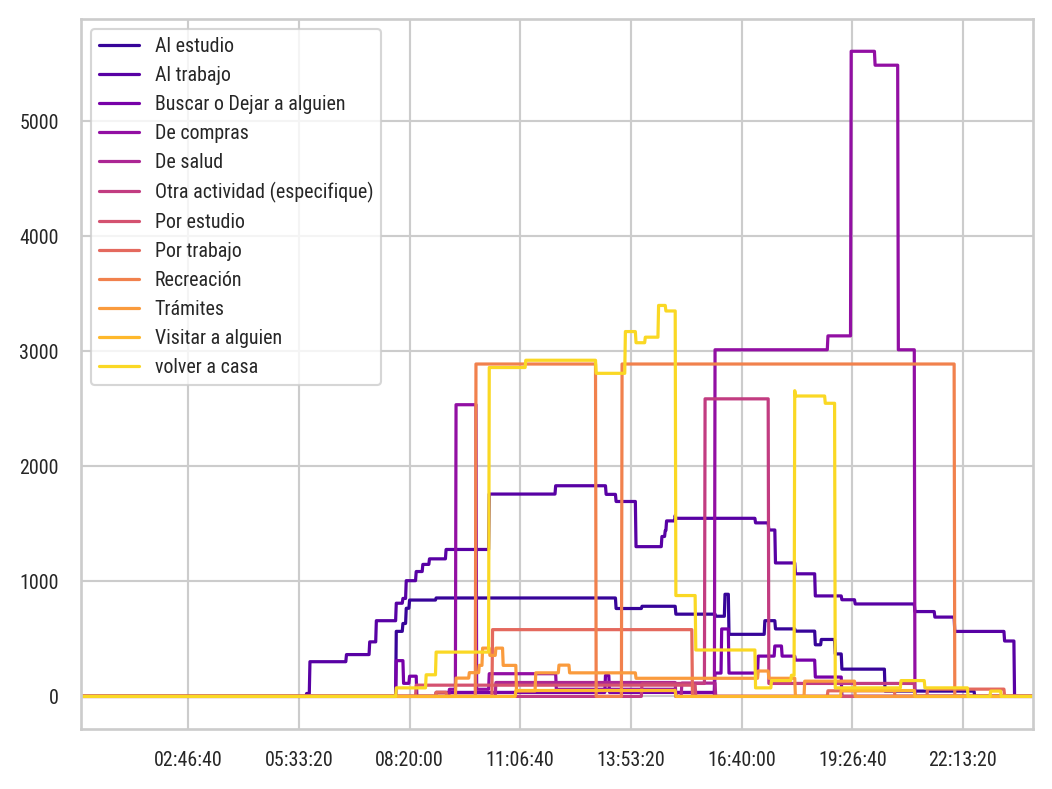

In [60]:
def calcular_matriz_de_tiempos(df):
    timeseries = pd.DataFrame(index=pd.timedelta_range(ejemplo['inicio_actividad'].min(), ejemplo['fin_actividad'].max(), freq='min'))
    for idx, group in df.groupby('Proposito'):
    
        group_ts = group.pipe(contar_minutos).groupby('minutos')['Peso'].sum().rename(idx)
        timeseries = timeseries.join(group_ts, how='left')

    return timeseries.fillna(0)

calcular_matriz_de_tiempos(ejemplo.head(100)).plot()

In [61]:
import numpy as np

matrices_de_tiempo = {}

for tipo_dia, group_tipo_dia in ejemplo.groupby('TipoDia'):
    matriz = group_tipo_dia.pipe(calcular_matriz_de_tiempos).fillna(0)
    matrices_de_tiempo[tipo_dia] = matriz

matrices_de_tiempo

{'Domingo':                  Al estudio  Al trabajo  Buscar o Dejar a alguien  \
 0 days 00:05:00         0.0         0.0                       0.0   
 0 days 00:06:00         0.0         0.0                       0.0   
 0 days 00:07:00         0.0         0.0                       0.0   
 0 days 00:08:00         0.0         0.0                       0.0   
 0 days 00:09:00         0.0         0.0                       0.0   
 ...                     ...         ...                       ...   
 0 days 23:55:00         0.0         0.0                       0.0   
 0 days 23:56:00         0.0         0.0                       0.0   
 0 days 23:57:00         0.0         0.0                       0.0   
 0 days 23:58:00         0.0         0.0                       0.0   
 0 days 23:59:00         0.0         0.0                       0.0   
 
                  Buscar o dejar algo  Comer o Tomar algo  De compras  \
 0 days 00:05:00                  0.0                 0.0         0.0   
 

In [62]:
matrices_de_tiempo.keys()

dict_keys(['Domingo', 'FindesemanaEstival', 'Laboral', 'LaboralEstival', 'Sábado'])

/home/egraells/miniconda3/envs/aves/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


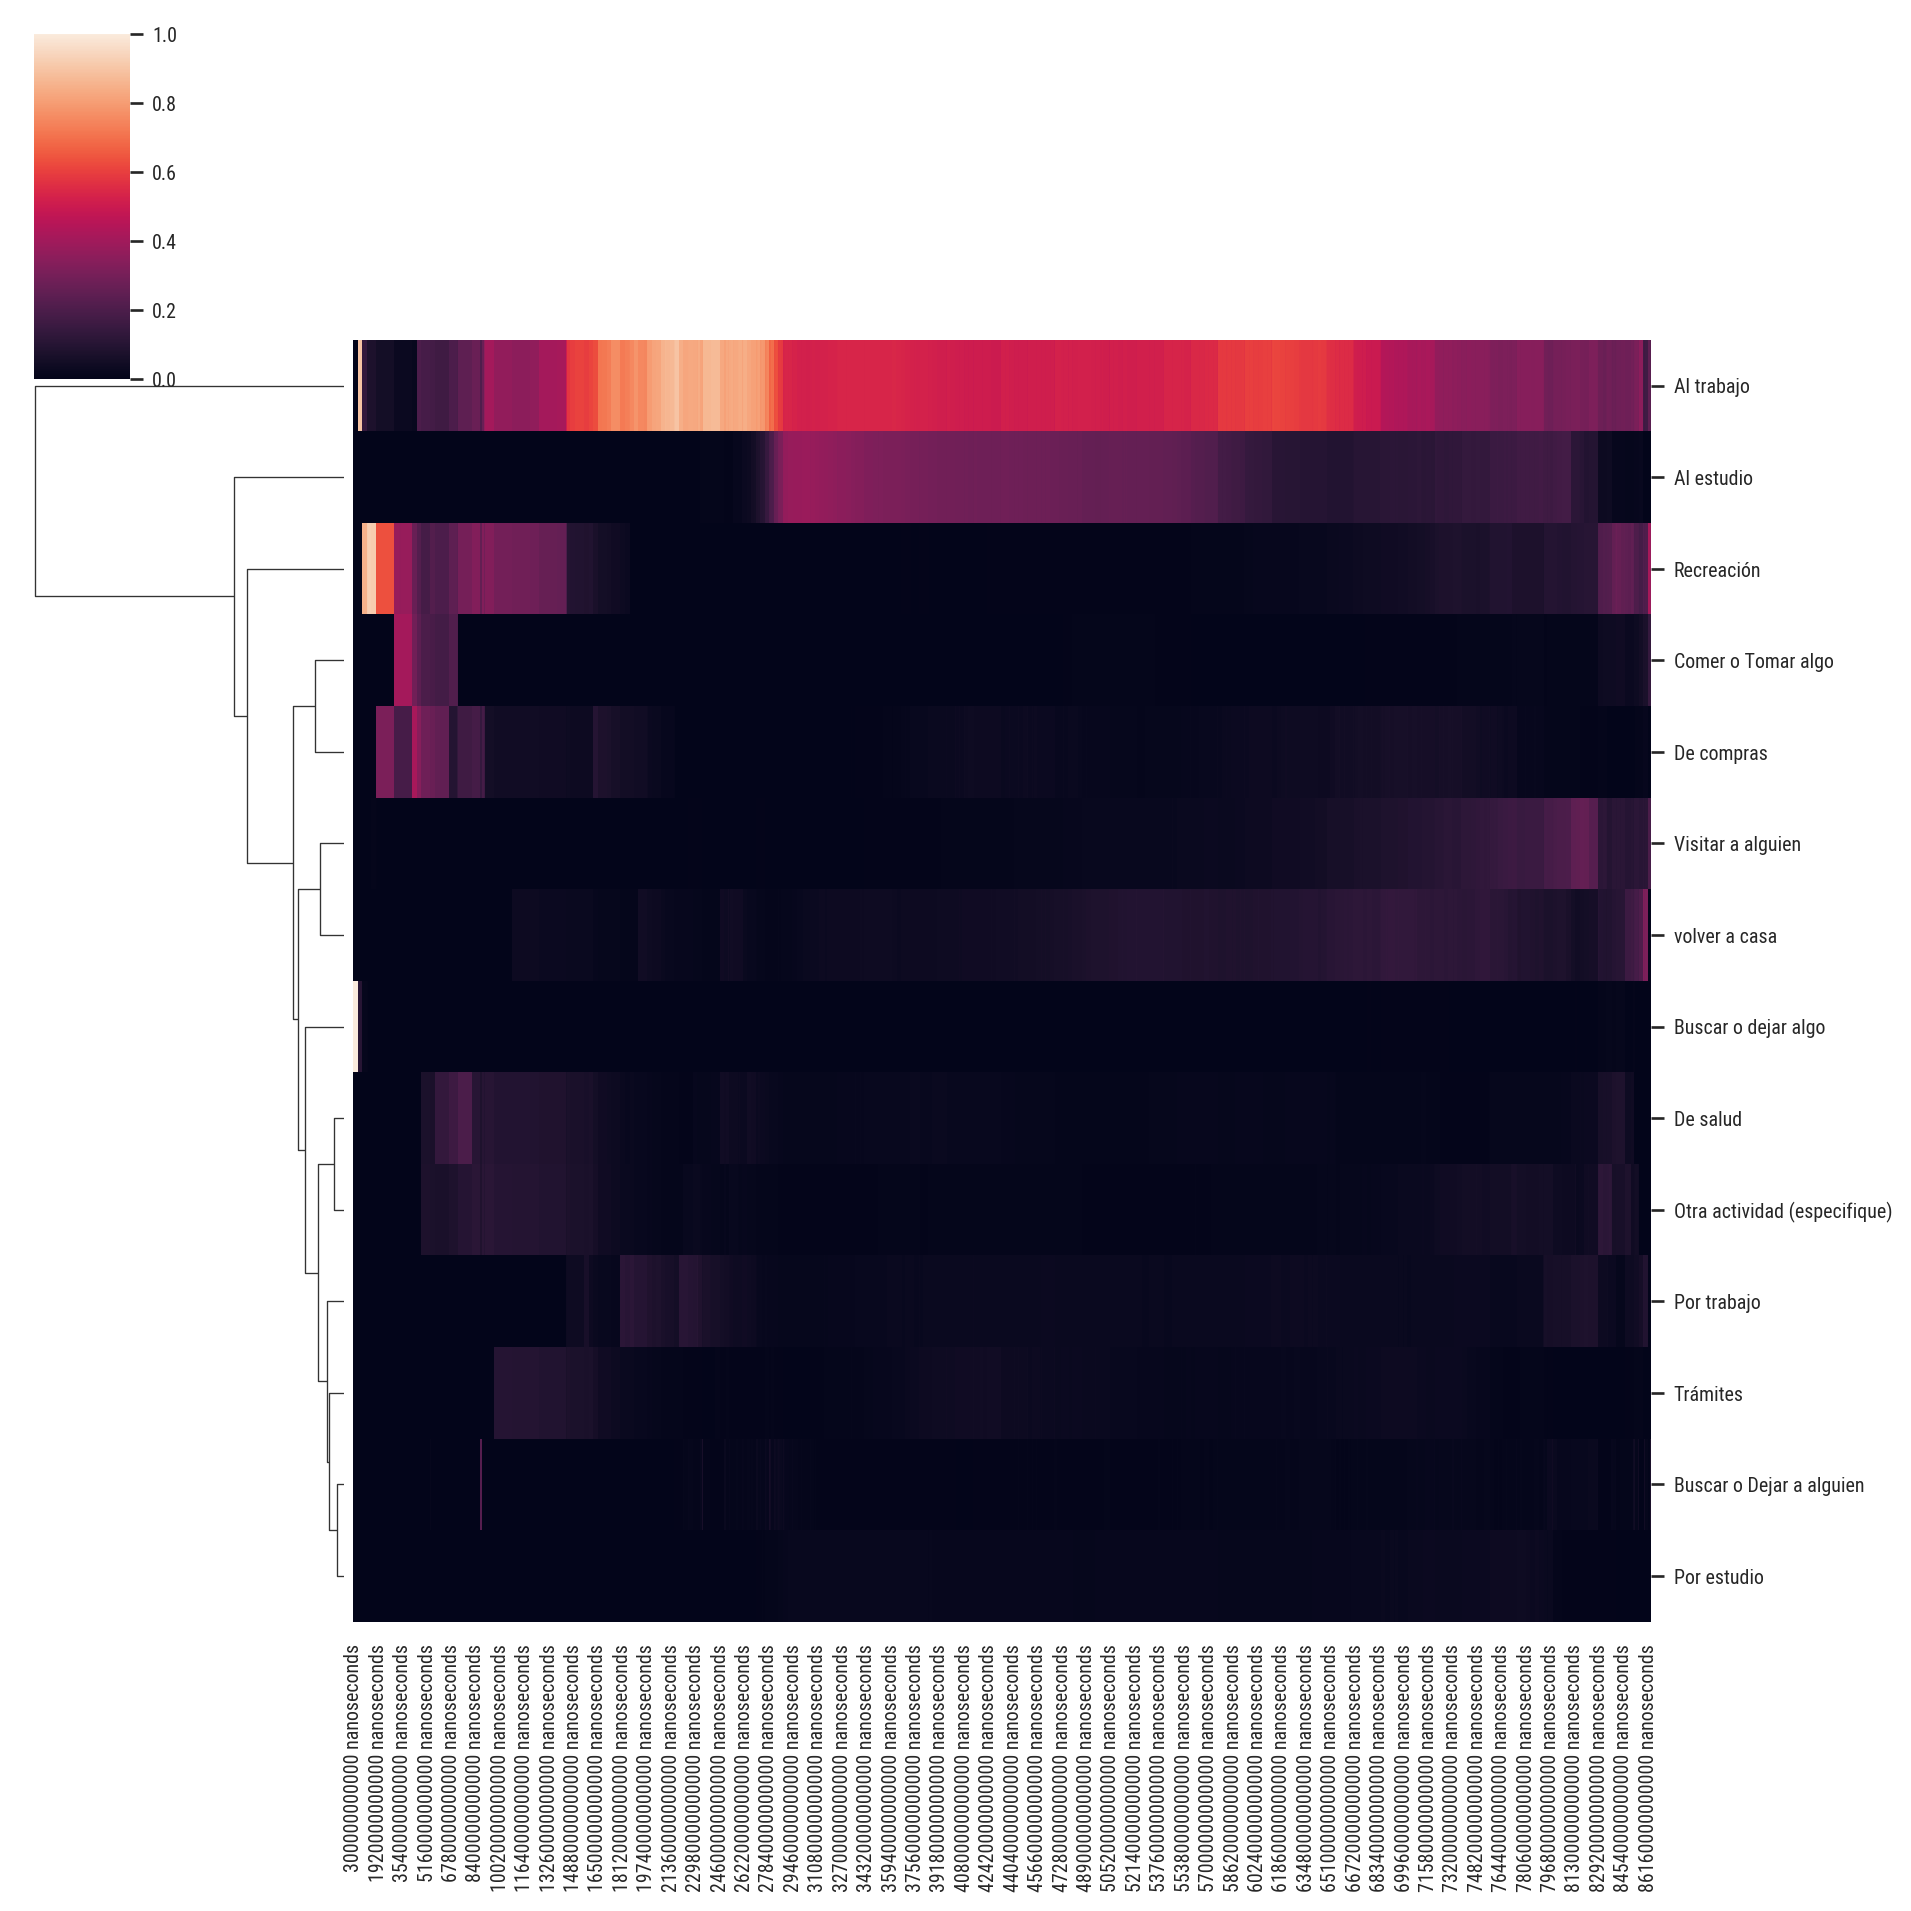

In [63]:
clusters = sns.clustermap(matrices_de_tiempo['Laboral'].T.pipe(normalize_columns), col_cluster=False, method='ward')

<Axes: >

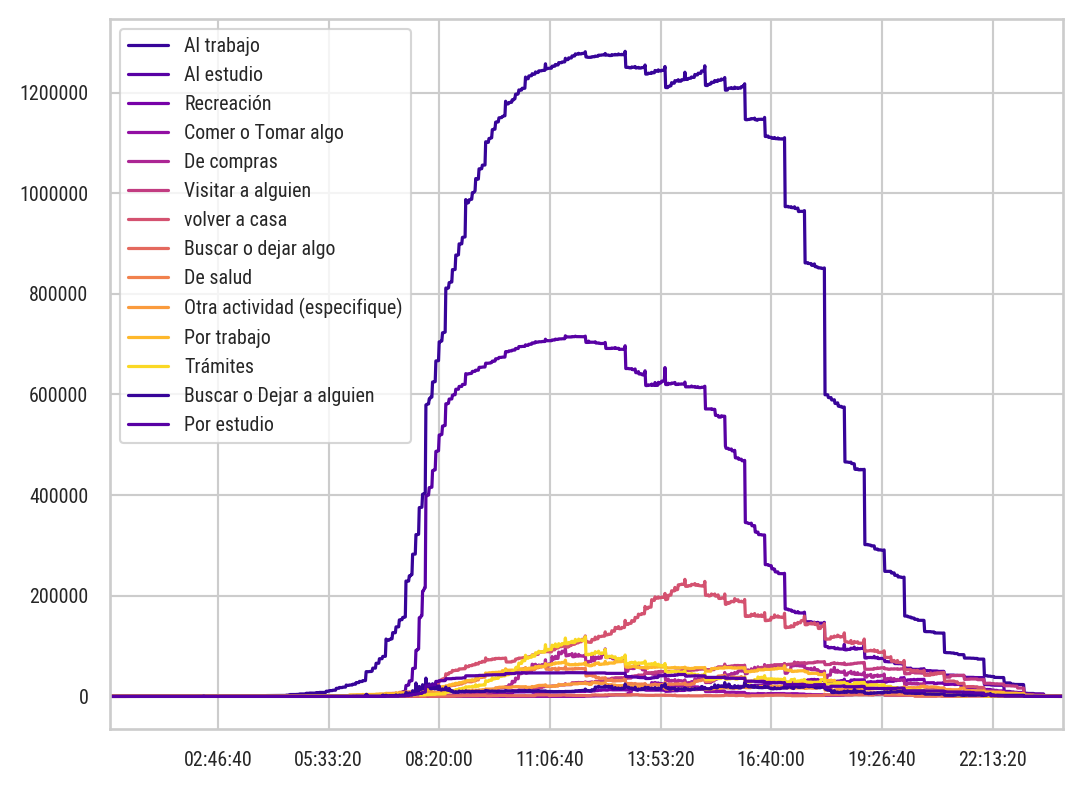

In [64]:
matrices_de_tiempo['Laboral'][clusters.data2d.index].plot()

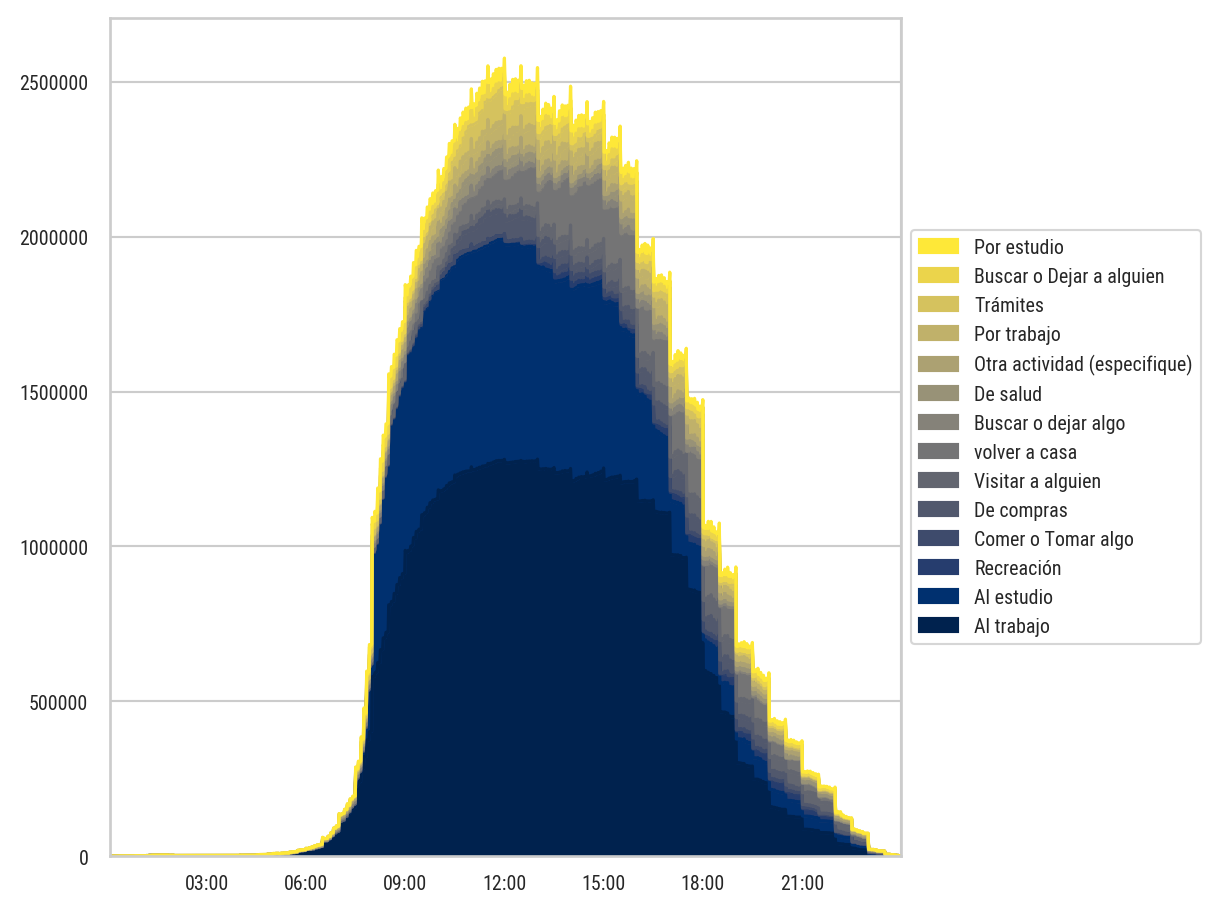

In [65]:
fig, ax = plt.subplots()

# un truco
matrices_de_tiempo['Laboral'][clusters.data2d.index].set_index(pd.to_datetime(matrices_de_tiempo['Laboral'].index.total_seconds(), unit='s')).plot(kind='area', stacked=True, cmap='cividis', ax=ax)

ax.legend(bbox_to_anchor=(1.0, 0.0, 0.1, 1.0), loc='center left', reverse=True)

fig.tight_layout()

In [66]:
from matplotlib.colors import ListedColormap
colors = sns.color_palette('husl', n_colors=len(clusters.data2d.index))
cmap = ListedColormap(colors)
colors


[(0.9677975592919913, 0.44127456009157356, 0.5358103155058701),
 (0.9386807511529497, 0.48901639250529133, 0.19623149776413562),
 (0.7757319041862729, 0.5784925270759935, 0.19475566538551875),
 (0.6566480096570136, 0.6229564921397143, 0.1938976562578914),
 (0.5105309046900421, 0.6614299289084904, 0.1930849118538962),
 (0.19468252393000074, 0.6998280342882891, 0.3041476695746048),
 (0.20433460114757862, 0.6863857739476534, 0.5407103379425205),
 (0.21044753832183283, 0.6773105080456748, 0.6433941168468681),
 (0.21662978923073606, 0.6676586160122123, 0.7318695594345369),
 (0.2266813382629933, 0.6508721810235698, 0.85618939194681),
 (0.5049017849530067, 0.5909119231215284, 0.9584657252128558),
 (0.7563369715809057, 0.5008642633638004, 0.9580503362615219),
 (0.9587050080494409, 0.3662259565791742, 0.9231469575614251),
 (0.9640248692994725, 0.41206779951067346, 0.7303540600728443)]

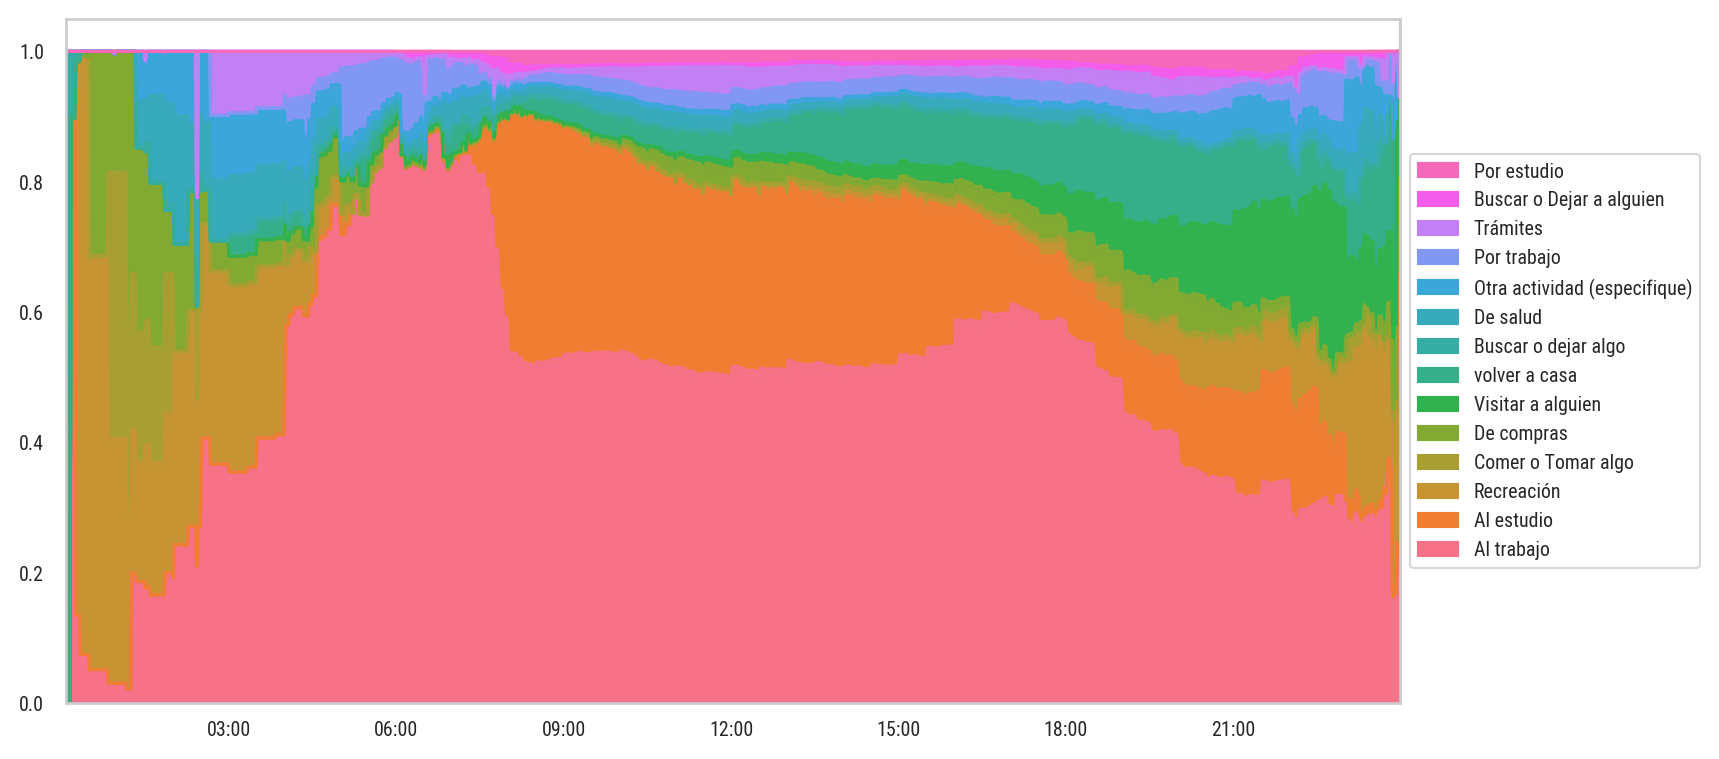

In [67]:
from aves.features.utils import normalize_rows

fig, ax = plt.subplots(figsize=(9, 4))

def plot_area(ax, df):
    # un truco
    df.set_index(pd.to_datetime(df.index.total_seconds(), unit='s')).pipe(normalize_rows).plot(kind='area', stacked=True, cmap=cmap, ax=ax)

plot_area(ax, matrices_de_tiempo['Laboral'][clusters.data2d.index])

ax.legend(bbox_to_anchor=(1.0, 0.0, 0.1, 1.0), loc='center left', reverse=True)

fig.tight_layout()

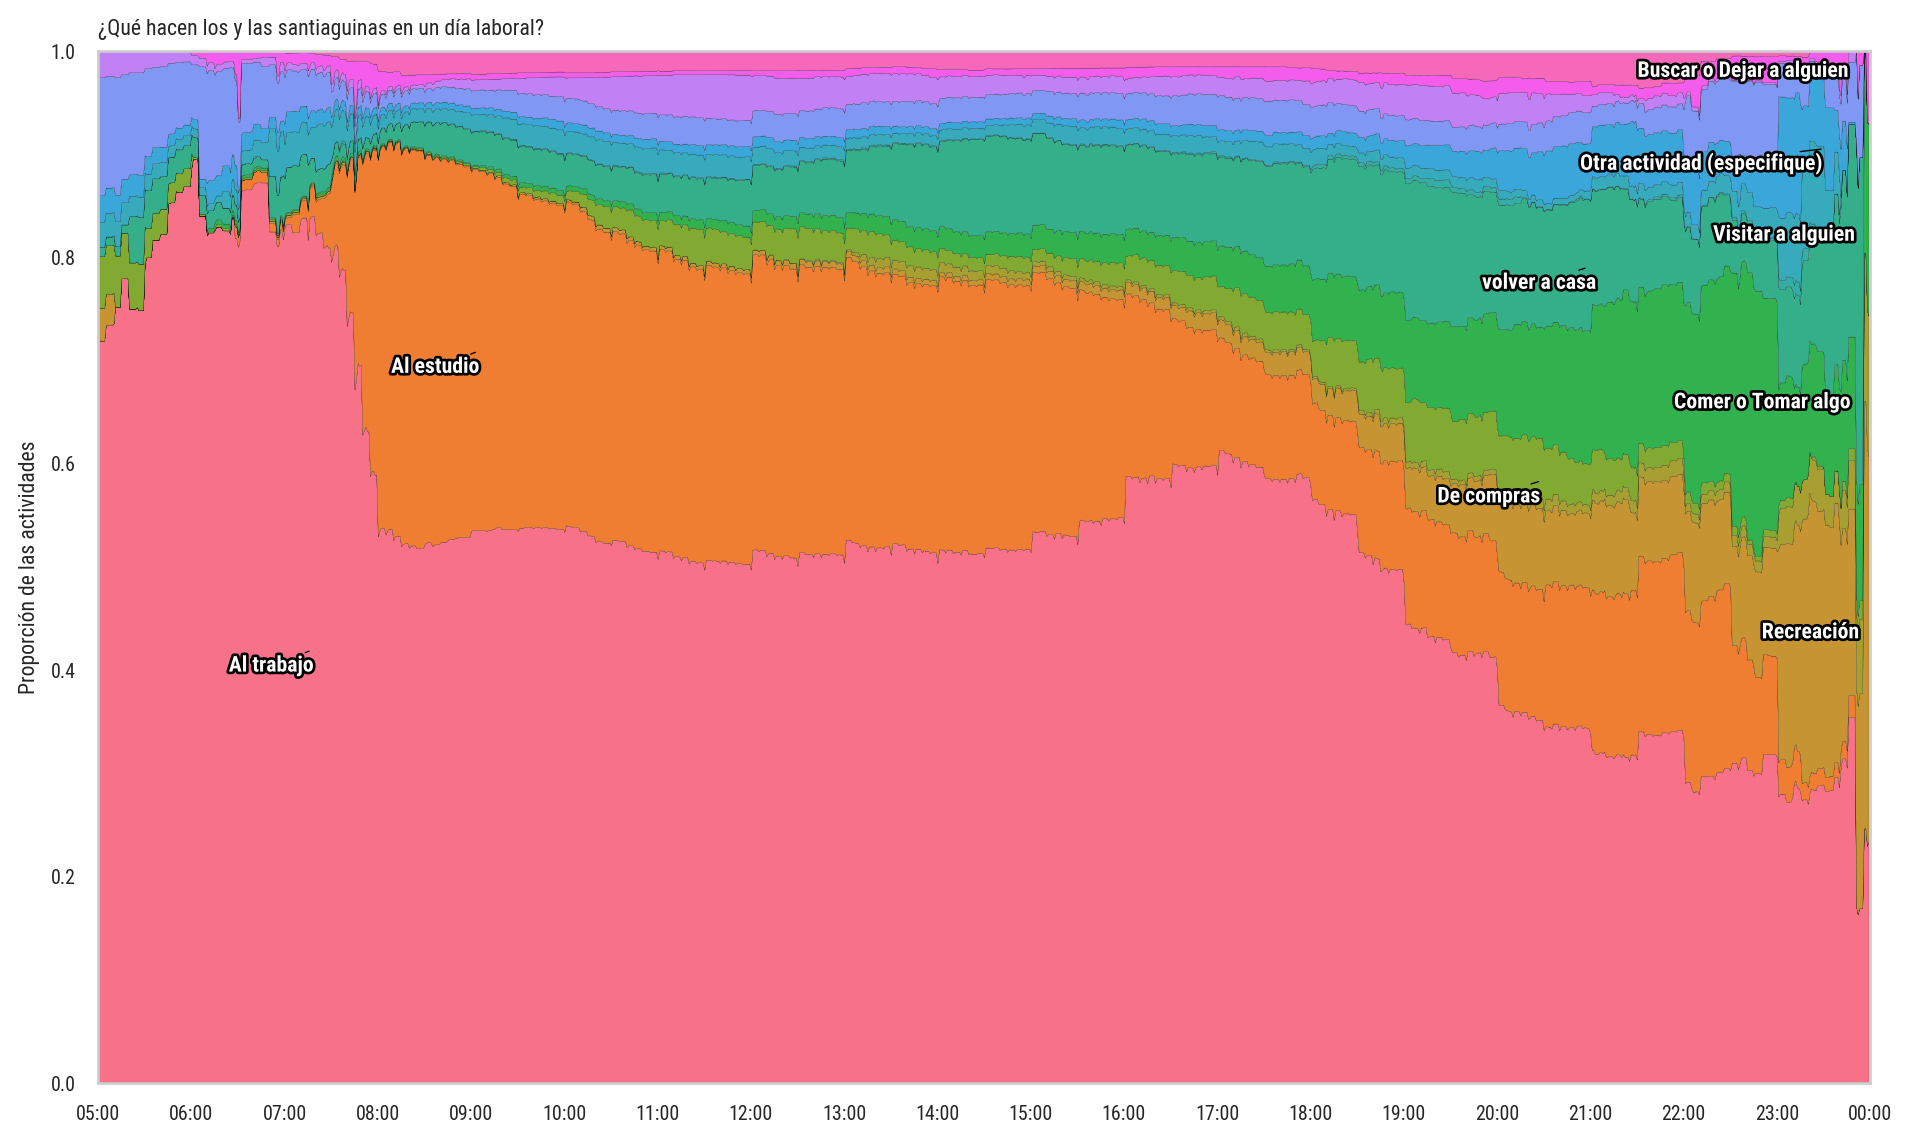

In [68]:
from aves.visualization.tables import streamgraph
import matplotlib.dates as mdates

fig, ax = plt.subplots(figsize=(10, 6))

# Primero convertimos a datetime
def stream_area(df):
    return df.set_index(pd.to_datetime(df.index.total_seconds(), unit='s')).pipe(normalize_rows)

df_datetime = stream_area(matrices_de_tiempo['Laboral'][clusters.data2d.index])

# Identificar el día presente en los datos
dia_base = df_datetime.index[0].date()

# Crear límites explícitos de tiempo
hora_inicio = pd.Timestamp(dia_base).replace(hour=5, minute=0)
hora_fin = pd.Timestamp(dia_base + pd.Timedelta(days=1)).replace(hour=0, minute=0)

# Filtrar usando los límites explícitos
vis_df = df_datetime[(df_datetime.index >= hora_inicio) & (df_datetime.index <= hora_fin)].pipe(normalize_rows)

ax.set_xlim([vis_df.index.min(),vis_df.index.max()])

ax.set_ylim([0,1])
streamgraph(
    ax,
    vis_df,
    baseline="zero",
    label_threshold=0.05,
    avoid_label_collisions=True,
    area_colors=dict(zip(clusters.data2d.index, colors)),
    area_args=dict(edgecolor="black", linewidth=0.075),
    label_collision_args=dict(
            iter_lim=100, arrowprops=dict(arrowstyle="-", color="k", lw=0.5)
    ),
    label_rolling_window=128
)

# Configurar formato de hora
hora_fmt = mdates.DateFormatter('%H:%M')
ax.xaxis.set_major_formatter(hora_fmt)

# Especificar manualmente los ticks para asegurar que aparezca medianoche
horas = list(range(5, 24)) + [0]  # 6 AM hasta medianoche (0)
fechas_ticks = [pd.Timestamp(dia_base).replace(hour=h) for h in horas[:-1]] + [hora_fin]
ax.set_xticks(fechas_ticks)


ax.grid(True, linestyle='dotted', color='#efefef')
ax.set_title('¿Qué hacen los y las santiaguinas en un día laboral?', loc='left')
ax.set_ylabel('Proporción de las actividades')

fig.tight_layout()

¡Es un buen comienzo! Sin embargo, todavía falta mucho por hacer. Algunas ideas:

- ¿Hay diferencias de género, edad y otros grupos?
- El gráfico no normalizado debiese tener siempre la misma cantidad de personas en cada instante del día. Entonces, ¿Cómo incluir a la gente que no realizó viajes? ¿Cómo incluir el antes y el después de los viajes? 

Las mejoras al gráfico de tipo estético y funcional las veremos en las siguientes clases.

## Sobre herramientas y Python

Con estas herramientas podemos explorar las relaciones que hay entre las variables de nuestro dataset. Concluimos que la mayor dificultad no está en _implementar_ las visualizaciones, sino en, primero, **saber qué preguntarle a los datos**, y segundo, **elegir los métodos adecuados para responder la pregunta**. Probablemente seaborn, pandas o matplotlib tienen dicha solución implementada, o al menos a unos pasos de ser implementada. También podemos utilizar los métodos implementados en aves.

El siguiente paso es entender cómo se comportan estos métodos con otras variables del dataset. También hemos probado distintos valores para atributos de apariencia, como los tamaños de figura y las paletas de colores.

Una dificultad en el aprendizaje es que no existen estándares para nombrar a los métodos y sus parámetros. Por ejemplo, el parámetro de la paleta de colores se suele llamar `cmap` en `matplotlib` y `pandas`, pero se llama `palette` en casi todos los métodos de `seaborn` --- digo casi todos porque algunos también usan `cmap`. Esto puede ser confuso para aprender, y creo que de momento no hay una solución más que ejercitar y aprenderse los nombres de parámetros y de métodos que sean más adecuados para la tarea a resolver.